In [11]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd

import concurrent.futures
from pm4py.objects.conversion.log import converter as log_converter

from create_sample import create_sample_log
MAC = True

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [17]:
if MAC:
    df_path = '/Users/urszulajessen/code/gitHub/WISE/wise_flow/data/BPI_Challenge_2019.csv'
    df_sample = '/Users/urszulajessen/code/gitHub/WISE/wise_flow/tests/data/BPI_Challenge_2019_sample.xes'
    test_data_folder = '/Users/urszulajessen/code/gitHub/WISE/wise_flow/tests/data/'
else:
    df_path = 'C:\Code\Github\WISE\wise_flow\data\BPI_Challenge_2019.csv'
    df_sample = 'C:\Code\Github\WISE\wise_flow\\tests\data\BPI_Challenge_2019_sample.xes'
    test_data_folder = 'C:\Code\Github\WISE\wise_flow\\tests\data\\'
    
dataframe = pd.read_csv(df_path, sep=',')
#log = create_sample_log(dataframe, 1000)
full_log = pm4py.format_dataframe(dataframe, case_id='case_concept_name', activity_key='event_concept_name', timestamp_key='event_time_timestamp')
log = pm4py.read_xes(df_sample)
start_activities = pm4py.get_start_activities(log)
end_activities = pm4py.get_end_activities(log)
print(f"Start activities: {start_activities} \nEnd activities: {end_activities} \n")
print(f"Number of traces: {len(full_log)}")
print(f"columns: {full_log.columns}")
activities = full_log.event_concept_name.value_counts()
print(f"Activities: {activities}")

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

Start activities: {'Vendor creates invoice': 84, 'SRM: Created': 2, 'Record Goods Receipt': 148, 'Clear Invoice': 73, 'Create Purchase Order Item': 425, 'Delete Purchase Order Item': 3, 'Change Quantity': 11, 'Record Invoice Receipt': 101, 'Create Purchase Requisition Item': 108, 'Reactivate Purchase Order Item': 1, 'Change Approval for Purchase Order': 4, 'Receive Order Confirmation': 9, 'Vendor creates debit memo': 2, 'Record Service Entry Sheet': 7, 'Cancel Invoice Receipt': 4, 'Remove Payment Block': 14, 'Cancel Goods Receipt': 1, 'Set Payment Block': 1, 'Change Price': 2} 
End activities: {'Vendor creates invoice': 70, 'Cancel Goods Receipt': 3, 'Clear Invoice': 353, 'Record Invoice Receipt': 219, 'Create Purchase Order Item': 107, 'Record Goods Receipt': 128, 'Remove Payment Block': 50, 'Receive Order Confirmation': 13, 'Delete Purchase Order Item': 21, 'Cancel Invoice Receipt': 7, 'Change Price': 6, 'Change Quantity': 6, 'Vendor creates debit memo': 2, 'Change Approval for Purch

\textbf{Definition (Generalized Process Norm):} A \textit{Generalized Process Norm} $N$ is a tuple $(E_N, \#_N)$, defined as follows:
- $E_N \subseteq E$ represents a predefined subset of mandatory events constituting the process norm.
- $\#_N = \#|_{E_N}$ denotes the restriction of the mapping $\#$ to the events in $E_N$, capturing only the attributes of these predefined events.

In this framework, the generalized process norm $N$ focuses on the presence of essential events without imposing an order among them, thus $N = (E_N, \#_N)$, omitting the strict partial ordering $\prec$.

Building upon the Generalized Process Norm $N = (E_N, \#_N)$, we introduce a multi-layered framework to capture intricate process behaviors:

\textbf{Layer 1: Basic Norms} consists of the generalized process norm focusing on the presence of essential, predefined events.

\textbf{Layer 2: Sequential Norms} introduces $\Sigma \subseteq E \times E$, a set of ordered event pairs that must follow a mandatory sequence. For instance, if $(e_{\text{receive}}, e_{\text{pay}}) \in \Sigma$, receiving goods must precede the payment for those goods.

\textbf{Layer 3: Harmonization Norms} define a harmonization requirement across the process. Let $H \subseteq E$ denote the set of events that must be balanced. For example, if the process involves 50 purchase orders with 50 items, there should be an equal number of corresponding delivery and payment events, ensuring each item ordered is both delivered and paid for.

\textbf{Layer 4: Uniqueness Norms} specify events that should occur no more than once in a process instance. Let $U \subseteq E$ represent such unique events, deterring repetitions like double receiving goods or making duplicate payments.

\textbf{Layer 5: Avoidance Norms} outline activities that are considered undesirable within the process. Let $A \subseteq E$ identify these unwelcome events, which could include payment adjustments, unnecessary communications, or changes of currency.

Given:

- $sum\_counts_i = \sum_{j=1}^{n} value_{ij}$ for each row $i$ in the data, where $value_{ij}$ is the count of events in column $j$ for row $i$, and $n$ is the number of event columns.
- $basis\_count_i = value_{i,\text{basis}}$, the count in the basis column (the column specified for scoring) for row $i$.
- $col\_count = n$, the total number of event columns.
- $opt\_count_i = col\_count \cdot basis\_count_i$, the optimal count for row $i$, assuming equal distribution across all events.
- $diff\_count_i = |sum\_counts_i - opt\_count_i|$, the absolute difference between the sum of counts and the optimal count for row $i$.

Then, the score $S_i$ for each row $i$ is calculated as:

1. Calculate the minimum and maximum of $diff\_count_i$ across all rows:

   $min\_diff = \min(diff\_count_i)$
   
   $max\_diff = \max(diff\_count_i)$

2. Normalize $diff\_count_i$ to a score between 0 and 1:

   $S_i = 1 - \frac{diff\_count_i - min\_diff}{max\_diff - min\_diff}$

Here, $S_i$ is the score for row $i$, ranging from 0 to 1, where a score of 1 corresponds to the minimum difference and a score of 0 corresponds to the maximum difference.


In [50]:
def create_pivot(data, index_column, values_column='event_concept_name', columns=None):
    """
    Creates a pivot table that counts occurrences of distinct values in the values_column
    for each unique value in the index_column.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - index_column: The column to group by and display in the pivot table's index.
    - values_column: The column for which to count distinct values (default 'event_concept_name').

    Returns:
    - pivot_table: A pandas DataFrame representing the pivot table.
    """
    if columns:
        #filter data to only include values_column in columns and index_column
        data = data[data[values_column].isin(columns)]
    # Create pivot table with counts of each 'event_concept_name' for the specified 'index_column'
    pivot_table = pd.pivot_table(data, index=index_column, columns=values_column, aggfunc='size', fill_value=0)
    return pivot_table

activities = full_log.event_concept_name.unique().tolist()
def calculate_rework_for_document(trace):
    """
    Placeholder function for calculating rework for a given trace.
    This should be adjusted based on the actual implementation details of how rework is computed.
    """
    # Convert trace to event log if necessary
    # log = log_converter.apply(trace)
    # rework = pm4py.get_rework_cases_per_activity(log)
    # For the sake of example, return a dummy rework dictionary
    rework = {"dummy_activity": 1}
    return trace['case_Purchasing_Document'].iloc[0], rework

def create_rework_pivot_table(data, index_column='case_Purchasing_Document', columns=activities):
    pivot_table = pd.DataFrame(index=data[index_column].unique(), columns=columns)
    pivot_table = pivot_table.fillna(0)

    traces = [data[data[index_column] == doc] for doc in pivot_table.index]

    with concurrent.futures.ProcessPoolExecutor() as executor:
        future_to_doc = {executor.submit(calculate_rework_for_document, trace): trace for trace in traces}
        for future in concurrent.futures.as_completed(future_to_doc):
            PO_Document, rework = future.result()
            for activity in rework:
                pivot_table.at[PO_Document, activity] = rework[activity]

    pivot_table['score_rework'] = pivot_table.sum(axis=1)

    return pivot_table

def calculate_scores_basic(data, column_name, power_calc=False, power=2):
    """
    Calculate scores for each case_Purchasing_Document based on the specified column,
    where scores are between 0 and 1. A score of 1 corresponds to the row with the minimum
    difference in count, and a score of 0 corresponds to the row with the maximum difference.
    Intermediate values are scaled based on their deviation from the min and max differences.
    Optionally apply a power transformation to adjust the score distribution.

    Parameters:
    - data: DataFrame containing the dataset.
    - column_name: The name of the column to calculate scores based on.
    - power_calc: Boolean, whether to apply a power transformation to the scores.
    - power: The exponent to use in the power transformation if power_calc is True.

    Returns:
    - scores: A Series with scores for each case_Purchasing_Document.
    """
    # For each row, calculate the sum of all values in the row
    sum_counts = data.sum(axis=1)
    # Find the basis_value as value from the column with column_name
    basis_count = data[column_name]
    # Calculate optimal count as the col_count * basis_count
    col_count = data.shape[1]
    opt_count = col_count * basis_count
    # Calculate the difference between the sum_counts and the optimal count
    diff_count = abs(sum_counts - opt_count)
    
    # Normalize the diff_count to be between 0 and 1
    min_diff = diff_count.min()
    max_diff = diff_count.max()
    if max_diff - min_diff > 0:  # Prevent division by zero
        scores = 1 - ((diff_count - min_diff) / (max_diff - min_diff))
    else:
        scores = pd.Series([1]*len(diff_count), index=diff_count.index)  # All scores are 1 if no variance

    # Apply power transformation if requested
    if power_calc:
        scores = scores ** power

    data['score_basic'] = scores

    return data

def calculate_scores_avoid(data):
    """
    Calculate scores for each case_Purchasing_Document based on the specified column,
    where scores are between 0 and 1. A score of 1 corresponds to the row with the minimum
    difference in count, and a score of 0 corresponds to the row with the maximum difference.
    Intermediate values are scaled based on their deviation from the min and max differences.
    Optionally apply a power transformation to adjust the score distribution.

    Parameters:
    - data: DataFrame containing the dataset.
    - column_name: The name of the column to calculate scores based on.
    - power_calc: Boolean, whether to apply a power transformation to the scores.
    - power: The exponent to use in the power transformation if power_calc is True.

    Returns:
    - scores: A Series with scores for each case_Purchasing_Document.
    """
    # For each row, calculate the sum of all values in the row
    sum_counts = data.sum(axis=1)
    # Find the basis_value as value from the column with column_name
    basis_count = 0
    
    data['score_avoid'] = basis_count - sum_counts

    return data



def add_scores_to_log(data, scores, score_column_name='score', merge_on='case_Purchasing_Document'):
    """
    Adds scores to the original log DataFrame.

    Parameters:
    - data: The original DataFrame (e.g., filtered_log).
    - scores: DataFrame containing scores, indexed or keyed by the merge_on column.
    - score_column_name: The name of the column where scores will be stored.
    - merge_on: The column name or index name to merge on.

    Returns:
    - data_with_scores: The original DataFrame with an additional column for scores.
    """
    # Reset index if merging on index to ensure it becomes a mergeable column
    if scores.index.name == merge_on:
        scores_reset = scores.reset_index()
    else:
        scores_reset = scores.copy()

    # Merge scores into the original DataFrame
    data_with_scores = pd.merge(data, scores_reset[[merge_on, score_column_name]], on=merge_on, how='left')

    return data_with_scores

def get_total_score(data, score_columns=['score_basic', 'score_avoid'], weights=[0.6, 0.4]):
    # Check if the number of score columns matches the number of weights
    if len(score_columns) != len(weights):
        raise ValueError("The number of score columns and weights must match.")
    
    # Normalize each score column and apply weights
    for score_col, weight in zip(score_columns, weights):
        min_val = data[score_col].min()
        max_val = data[score_col].max()
        
        # Normalize the column
        normalized_col = f'{score_col}_normalized'
        data[normalized_col] = (data[score_col] - min_val) / (max_val - min_val) if max_val != min_val else data[score_col]
        
        # Apply weight
        data[normalized_col] = data[normalized_col] * weight
    
    # Sum up the weighted scores to get the total score
    normalized_columns = [f'{col}_normalized' for col in score_columns]
    data['total_score_normalized'] = data[normalized_columns].sum(axis=1)
    
    return data

def plot_scores_boxplot(data, score_column_name, category_column, title=None):
    """
    Generates box plots for the scores of a specified column using Seaborn.

    Parameters:
    - data: DataFrame containing the dataset, including scores and category columns.
    - score_column_name: The name of the column in data that contains the scores.
    - category_column: The column in data for which to plot scores.

    Note: The function assumes that the `data` DataFrame already includes the scores.
    """
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility

    # Create the boxplot with enhanced aesthetics
    boxplot = sns.boxplot(
        x=category_column, 
        y=score_column_name, 
        data=data,
        width=0.5,  # Narrower boxes for sharper visualization
        palette="vlag",  # Use a visually appealing palette
        fliersize=3,  # Smaller flier size makes it easier to identify outliers
        linewidth=1.5  # Thicker lines for better visibility
    )

    # Enhance readability and visual appeal
    if title:
        boxplot.set_title(title, fontsize=16)
    else:
        boxplot.set_title(f'Enhanced Box Plot of {score_column_name} by {category_column}', fontsize=16)
    boxplot.set_xlabel(category_column, fontsize=14)
    boxplot.set_ylabel(score_column_name, fontsize=14)
    plt.xticks(rotation=45)  # Rotate category labels for better readability
    sns.despine(trim=True)  # Trim the axes for a cleaner look

    plt.tight_layout()  # Adjust layout to make room for the rotated category labels
    plt.show()

def plot_custom_boxplot(data, score_column_name, category_column,title=None):
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
    
    categories = data[category_column].unique()
    n_categories = len(categories)
    tail_lengths = []
    colors = []

    # Determine the tail length for each category and store the results
    for category in categories:
        category_data = data[data[category_column] == category][score_column_name]
        if not category_data.empty:
            q75, q25 = np.percentile(category_data, [75, 25])
            iqr = q75 - q25
            upper_whisker = q75 + (1.5 * iqr)
            lower_whisker = q25 - (1.5 * iqr)
            tail_length = upper_whisker - lower_whisker
            tail_lengths.append(tail_length)
        else:
            tail_lengths.append(0)  # Handle empty data by assigning a default tail length
    
    # Normalize tail lengths for color mapping
    max_tail_length = max(tail_lengths)
    normalized_tail_lengths = [length / max_tail_length if max_tail_length else 0 for length in tail_lengths]

    # Map normalized tail lengths to colors
    for length in normalized_tail_lengths:
        colors.append(plt.cm.RdYlGn(length))
    
    # Plot each category with its corresponding color
    for i, category in enumerate(categories):
        category_data = data[data[category_column] == category][score_column_name]
        if not category_data.empty:
            plt.boxplot(category_data, positions=[i], widths=0.5, patch_artist=True,
                        boxprops=dict(facecolor=colors[i], color='black'),
                        whiskerprops=dict(color='black'), capprops=dict(color='black'), 
                        flierprops=dict(color='black', markeredgecolor='black'),
                        medianprops=dict(color='black'))
    
    plt.xticks(range(n_categories), categories, rotation=45)
    if title:
        plt.title(title, fontsize=16)
    else:
        plt.title(f'Custom Box Plot of {score_column_name} by {category_column}', fontsize=16)
    plt.xlabel(category_column, fontsize=14)
    plt.ylabel(score_column_name, fontsize=14)
    sns.despine(trim=True)  # Trim the axes for a cleaner look
    plt.tight_layout()
    plt.show()


#{Layer 1: Basic Norms} consists of the generalized process norm focusing on the presence of essential, predefined events.
#{Layer 2: Sequential Norms} introduces $\Sigma \subseteq E \times E$, a set of ordered event pairs that must follow a mandatory sequence. For instance, if $(e_{\text{receive}}, e_{\text{pay}}) \in \Sigma$, receiving goods must precede the payment for those goods.
#{Layer 3: Harmonization Norms} define a harmonization requirement across the process. Let $H \subseteq E$ denote the set of events that must be balanced. For example, if the process involves 50 purchase orders with 50 items, there should be an equal number of corresponding delivery and payment events, ensuring each item ordered is both delivered and paid for.
#{Layer 4: Uniqueness Norms} specify events that should occur no more than once in a process instance. Let $U \subseteq E$ represent such unique events, deterring repetitions like double receiving goods or making duplicate payments.
#{Layer 5: Avoidance Norms}



dict_Weights = {
"Standard": {
"basic_events": ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"],
"sequential_events": [("Create Purchase Order Item", "Vendor Creates Invoice"), ("Vendor Creates Invoice", "Record Goods Receipt"), ("Record Goods Receipt", "Clear Invoice")],
"harmon_events": ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"],
"unique_events": [ "Record Goods Receipt", "Clear Invoice"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location', 'Change Currency' ,'Change payment term'
 'Change Rejection Indicator','Change Approval for Purchase Order', 'Change Quantity', 'Change Material', 'Change Vendor', 
 'Change Purchase Order Item', 'Cancel Goods Receipt' 'Cancel Invoice Receipt'],
},
"Service": {
"basic_events": ["Create Purchase Order Item",  "Record Goods Receipt"],
"sequential_events": [("Create Purchase Order Item", "Record Goods Receipt")],
"harmon_events": ["Create Purchase Order Item", "Record Goods Receipt",],
"unique_events": ["Record Goods Receipt"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location' 'Change Currency' ],
},
"Consignment": {
"basic_events": ["Create Purchase Order Item",  "Record Goods Receipt", "Record Service Entry Sheet"],
"sequential_events": [("Create Purchase Order Item", "Record Goods Receipt"), ("Record Goods Receipt", "Record Service Entry Sheet")],
"harmon_events": ["Create Purchase Order Item", "Record Goods Receipt"],
"unique_events": ["Record Goods Receipt"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location' 'Change Currency' ],
}
}

In [ ]:
activities = full_log.event_concept_name.unique().tolist()
def create_rework_pivot_table(data, index_column='case_Purchasing_Document', columns=activities):
    """
    Initializes a pivot table with specified columns and index, filling with zeros.
    
    Parameters:
    - data: DataFrame containing the dataset.
    - index_column: The column to use as the pivot table index.
    - columns: A list of columns to include in the pivot table.
    
    Returns:
    - pivot_table: An initialized pandas DataFrame.
    """
    pivot_table = pd.DataFrame(index=data[index_column].unique(), columns=columns)
    pivot_table = pivot_table.fillna(0)  # Fill NaN values with 0

    #for each case_Purchasing_Document in pivot_table calculate rework with pm4py.get_rework_cases_per_activity(here each case_Purchasing_Document)
    for PO_Document in pivot_table.index:
        trace = full_log[full_log['case_Purchasing_Document'] == PO_Document]
        rework = pm4py.get_rework_cases_per_activity(trace)
        for activity in rework:
            pivot_table.at[PO_Document, activity] = rework[activity]

    #summ all values for each case_Purchasing_Document and store it in a new column score_rework
    pivot_table['score_rework'] = pivot_table.sum(axis=1)
        
    return pivot_table


pivot_table_rework = create_rework_pivot_table(full_log, index_column='case_Purchasing_Document', columns=activities)
#print all activities with the number of rework cases, aggregate the number of rework cases for each activity and drop index column
table_activities_rework_count = pivot_table_rework.drop(columns='score_rework').sum().sort_values(ascending=False)
print(table_activities_rework_count)

pivot_table_rework.to_csv(f'{test_data_folder}pivot_table_rework_general.csv')

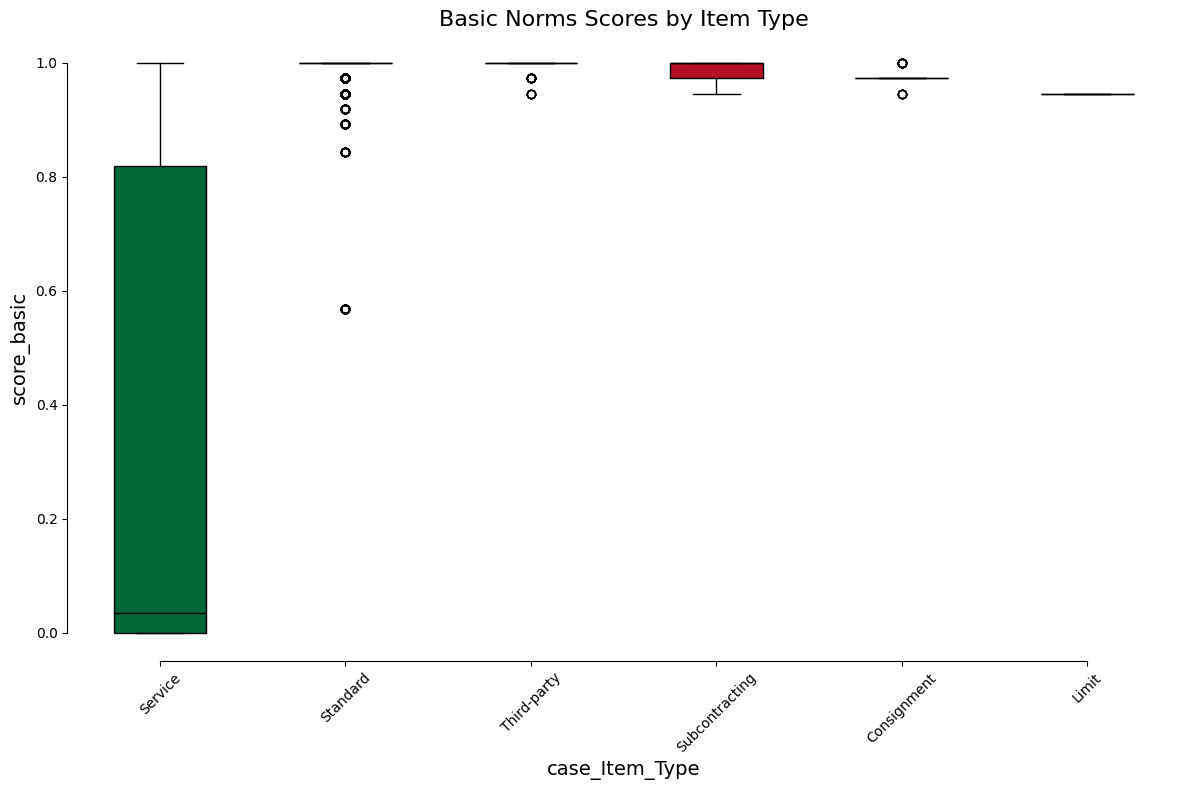

/var/folders/b8/ffvxv5g116l_p3gx35tljqzh0000gn/T/ipykernel_69162/3308832447.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


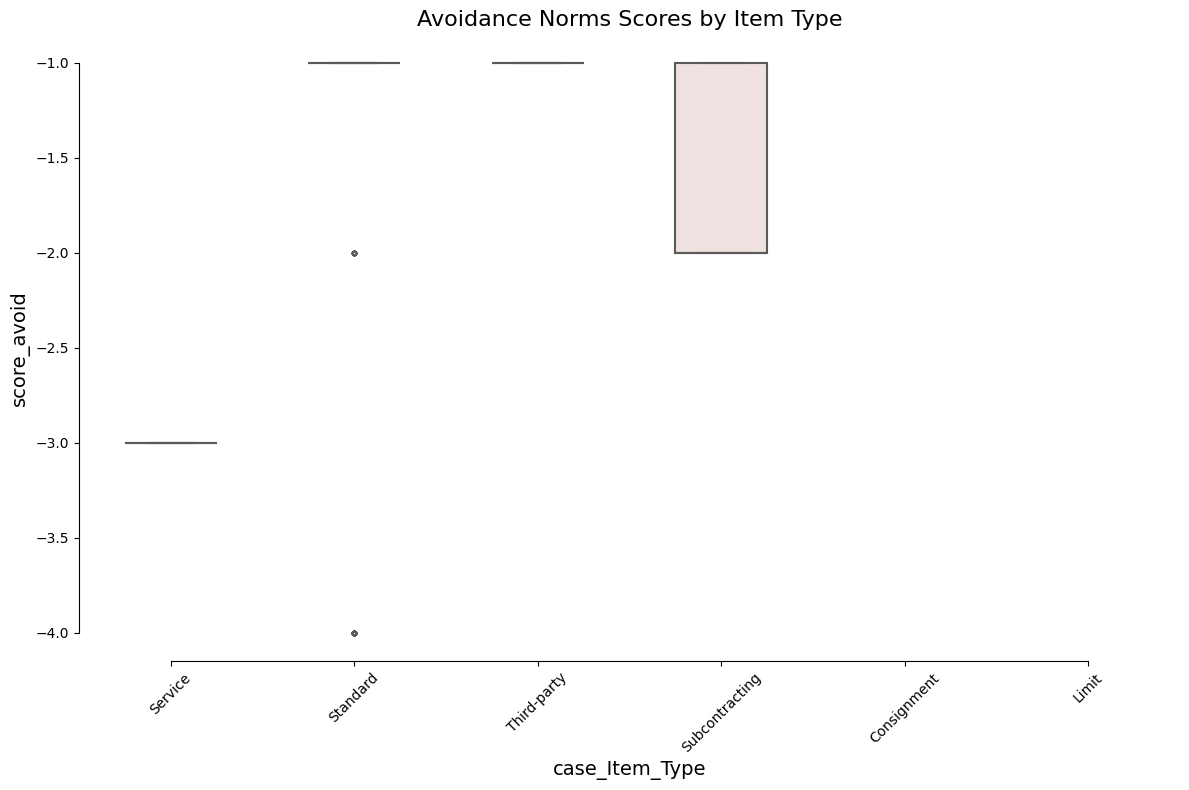

/var/folders/b8/ffvxv5g116l_p3gx35tljqzh0000gn/T/ipykernel_69162/3308832447.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


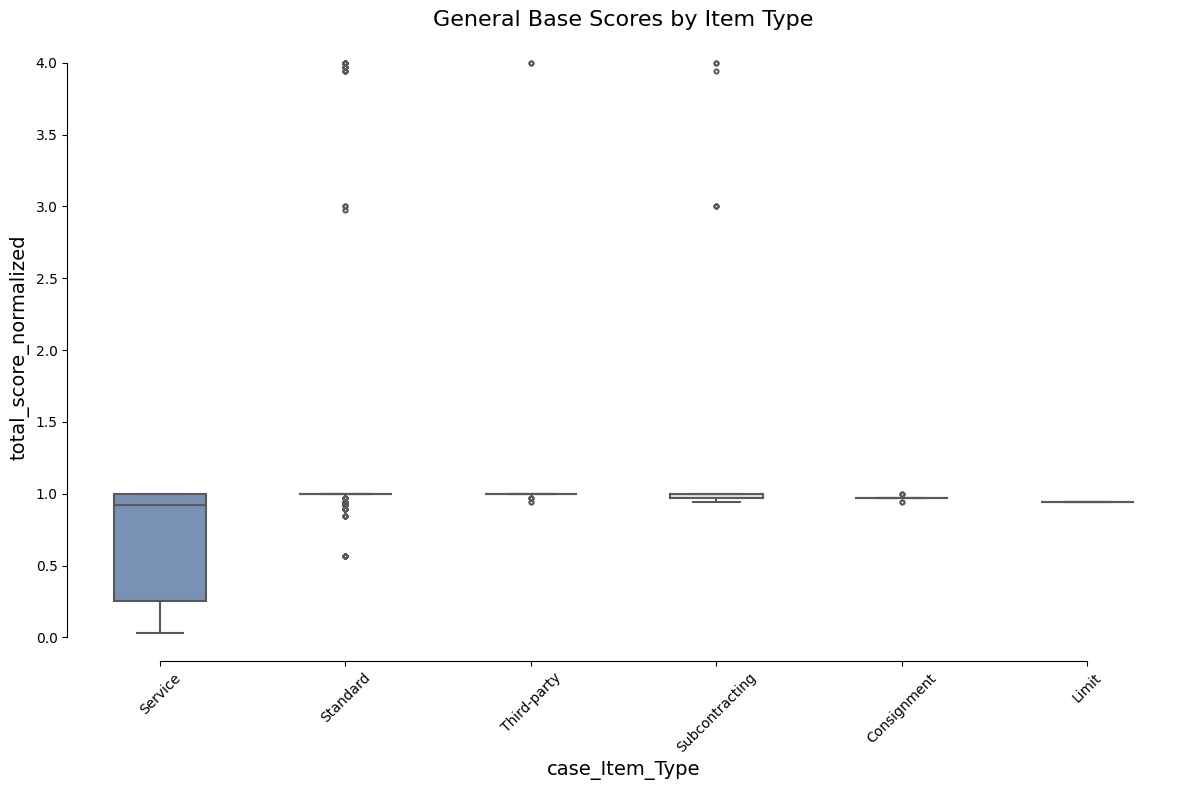

In [60]:
basic_events_general = ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"]
avoid_events_general = ["Change Price",'Change Storage Location', 'Change Currency'  'Change Quantity', 'Change Material', 'Change Vendor']


pivot_table_col_general = create_pivot(full_log, index_column='case_Purchasing_Document', columns=basic_events_general)
pivot_table_col_general = calculate_scores_basic(pivot_table_col_general, column_name='Create Purchase Order Item', power_calc=True, power=4)
filtered_log_with_scores = add_scores_to_log(full_log, pivot_table_col_general[['score_basic']], score_column_name='score_basic', merge_on='case_Purchasing_Document')
plot_custom_boxplot(filtered_log_with_scores, 'score_basic', 'case_Item_Type', title='Basic Norms Scores by Item Type')

pivot_table_neg_events_general = create_pivot(full_log, index_column='case_Purchasing_Document', columns=avoid_events_general)
pivot_table_neg_events_general = calculate_scores_avoid(pivot_table_neg_events_general)

# pivot_table_neg_events_general.to_csv('C:\Code\Github\WISE\wise_flow\\tests\data\pivot_table_col_general.csv')
filtered_log_with_scores = add_scores_to_log(filtered_log_with_scores, pivot_table_neg_events_general[['score_avoid']], score_column_name='score_avoid', merge_on='case_Purchasing_Document')
plot_scores_boxplot(filtered_log_with_scores, 'score_avoid', 'case_Item_Type', title='Avoidance Norms Scores by Item Type')

#create new column which contains the sum of all scores
data_total_scores = get_total_score(filtered_log_with_scores, score_columns=['score_basic', 'score_avoid'], weights=[1, 3])
plot_scores_boxplot(data_total_scores, 'total_score_normalized', 'case_Item_Type', title='General Base Scores by Item Type')

#pivot_table_rework_general = create_rework_pivot_table(full_log, index_column='case_Purchasing_Document', columns=activities)
#pivot_table_rework_general.to_csv('C:\Code\Github\WISE\wise_flow\\tests\data\pivot_table_rework_general.csv')
#filtered_log_with_scores = add_scores_to_log(filtered_log_with_scores, pivot_table_rework_general, merge_on='case_Purchasing_Document')
dict_Weights = {
"Standard": {
"basic_events": ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"],
"sequential_events": [("Create Purchase Order Item", "Vendor Creates Invoice"), ("Vendor Creates Invoice", "Record Goods Receipt"), ("Record Goods Receipt", "Clear Invoice")],
"harmon_events": ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"],
"unique_events": [ "Record Goods Receipt", "Clear Invoice"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location', 'Change Currency' ,'Change payment term'
 'Change Rejection Indicator','Change Approval for Purchase Order', 'Change Quantity', 'Change Material', 'Change Vendor', 
 'Change Purchase Order Item', 'Cancel Goods Receipt' 'Cancel Invoice Receipt'],
},
"Service": {
"basic_events": ["Create Purchase Order Item",  "Record Goods Receipt"],
"sequential_events": [("Create Purchase Order Item", "Record Goods Receipt")],
"harmon_events": ["Create Purchase Order Item", "Record Goods Receipt",],
"unique_events": ["Record Goods Receipt"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location' 'Change Currency' ],
},
"Consignment": {
"basic_events": ["Create Purchase Order Item",  "Record Goods Receipt", "Record Service Entry Sheet"],
"sequential_events": [("Create Purchase Order Item", "Record Goods Receipt"), ("Record Goods Receipt", "Record Service Entry Sheet")],
"harmon_events": ["Create Purchase Order Item", "Record Goods Receipt"],
"unique_events": ["Record Goods Receipt"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location' 'Change Currency' ],
}
}#plot_scores_boxplot(filtered_log_with_scores, 'score_rework', 'case_Item_Type')

/var/folders/b8/ffvxv5g116l_p3gx35tljqzh0000gn/T/ipykernel_69162/3308832447.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


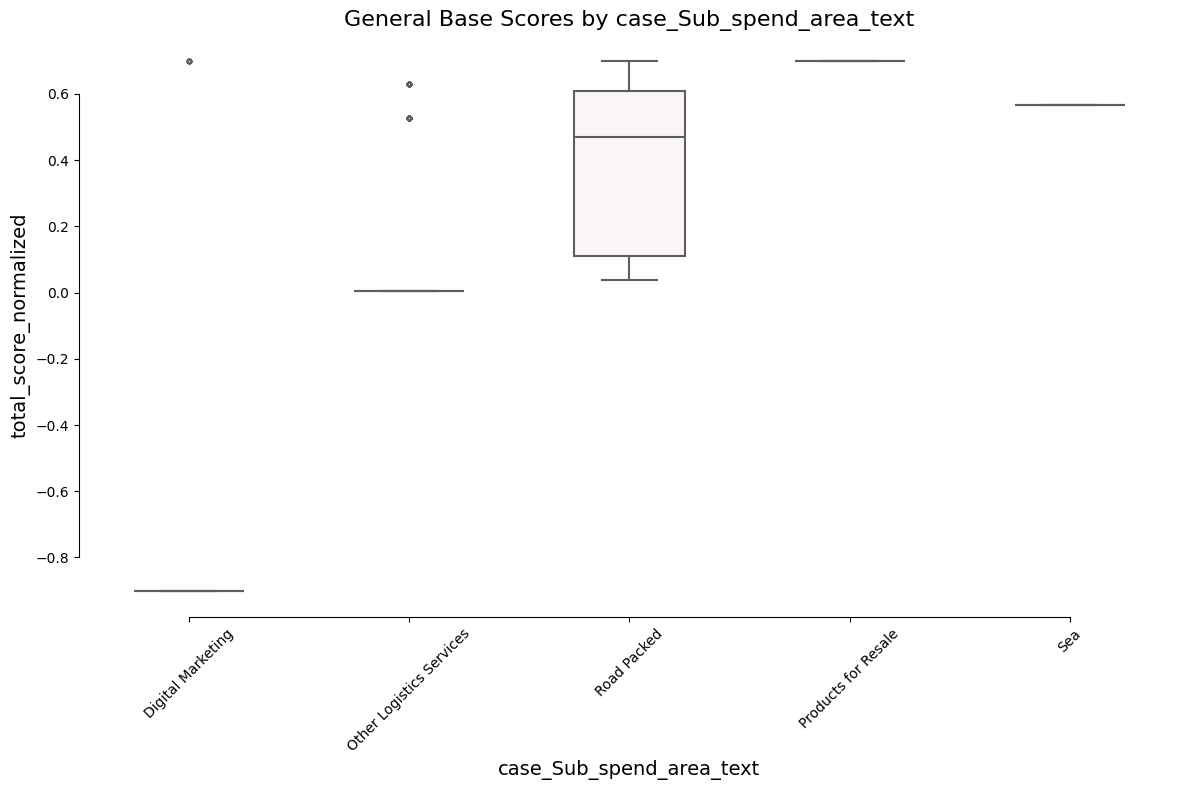

/var/folders/b8/ffvxv5g116l_p3gx35tljqzh0000gn/T/ipykernel_69162/3308832447.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


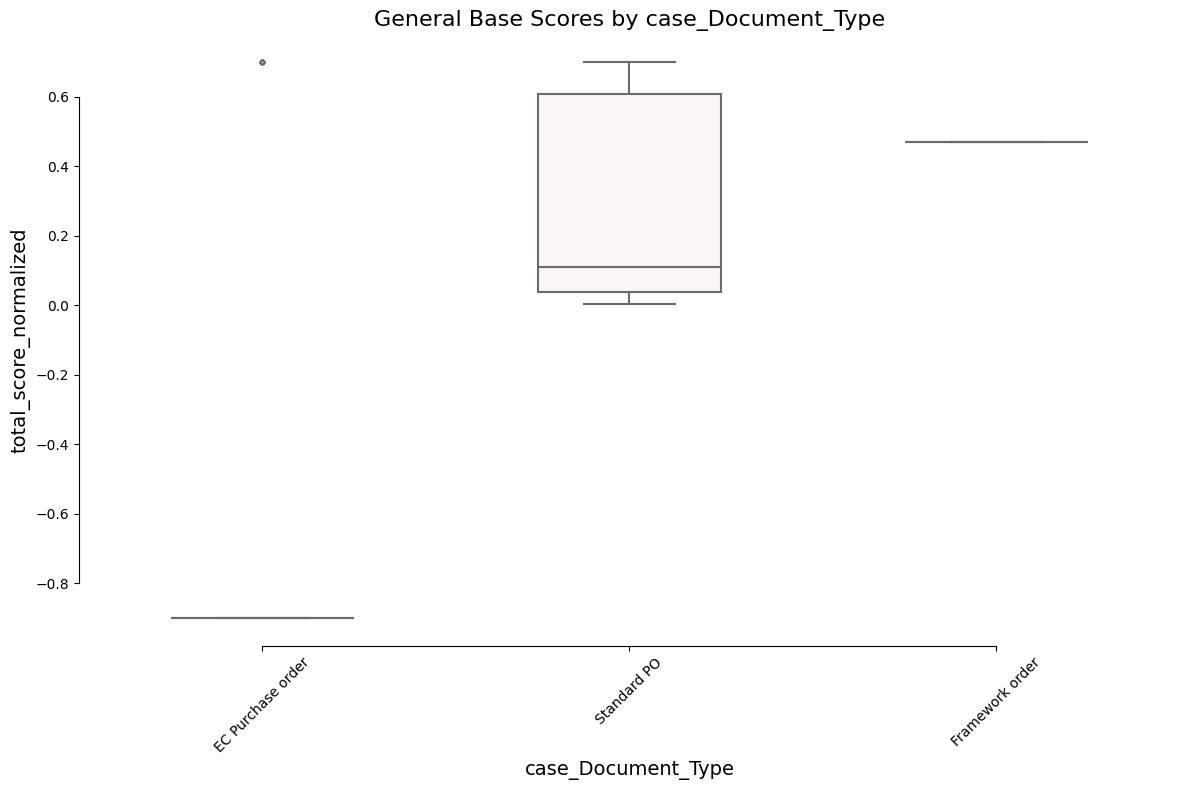

/var/folders/b8/ffvxv5g116l_p3gx35tljqzh0000gn/T/ipykernel_69162/3308832447.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


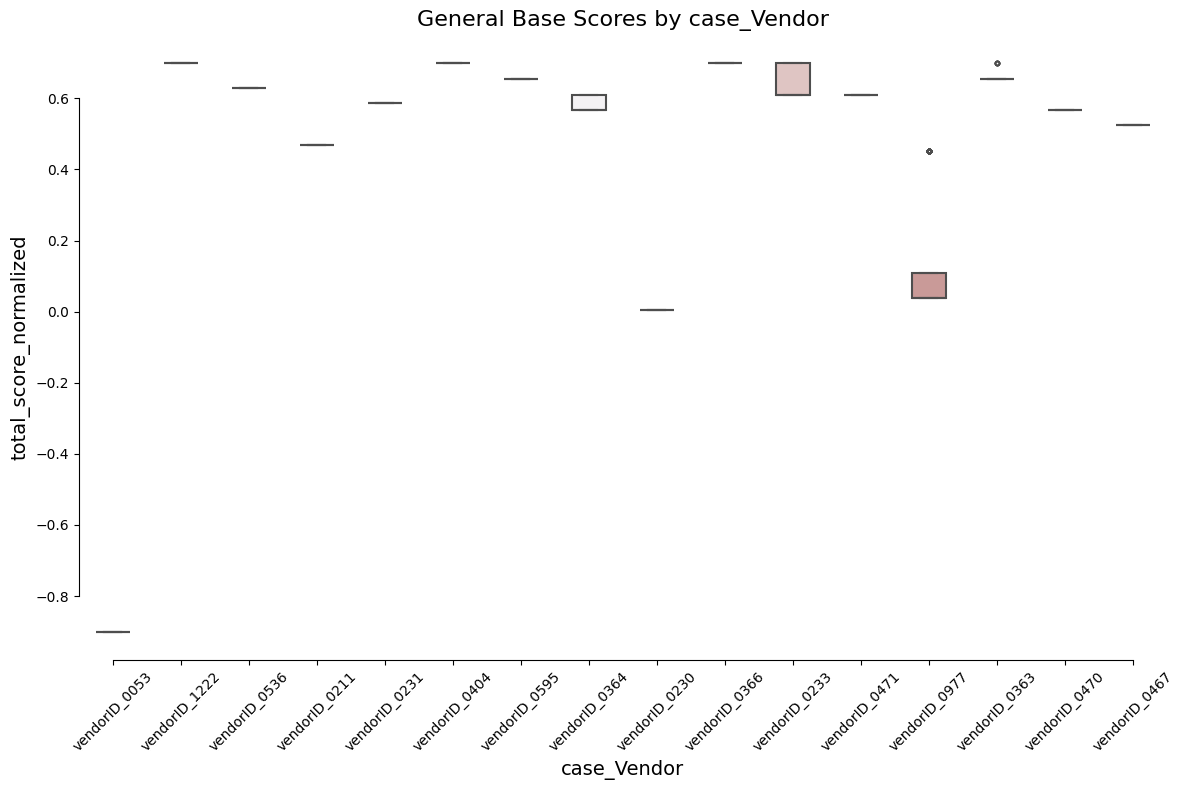

/var/folders/b8/ffvxv5g116l_p3gx35tljqzh0000gn/T/ipykernel_69162/3308832447.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


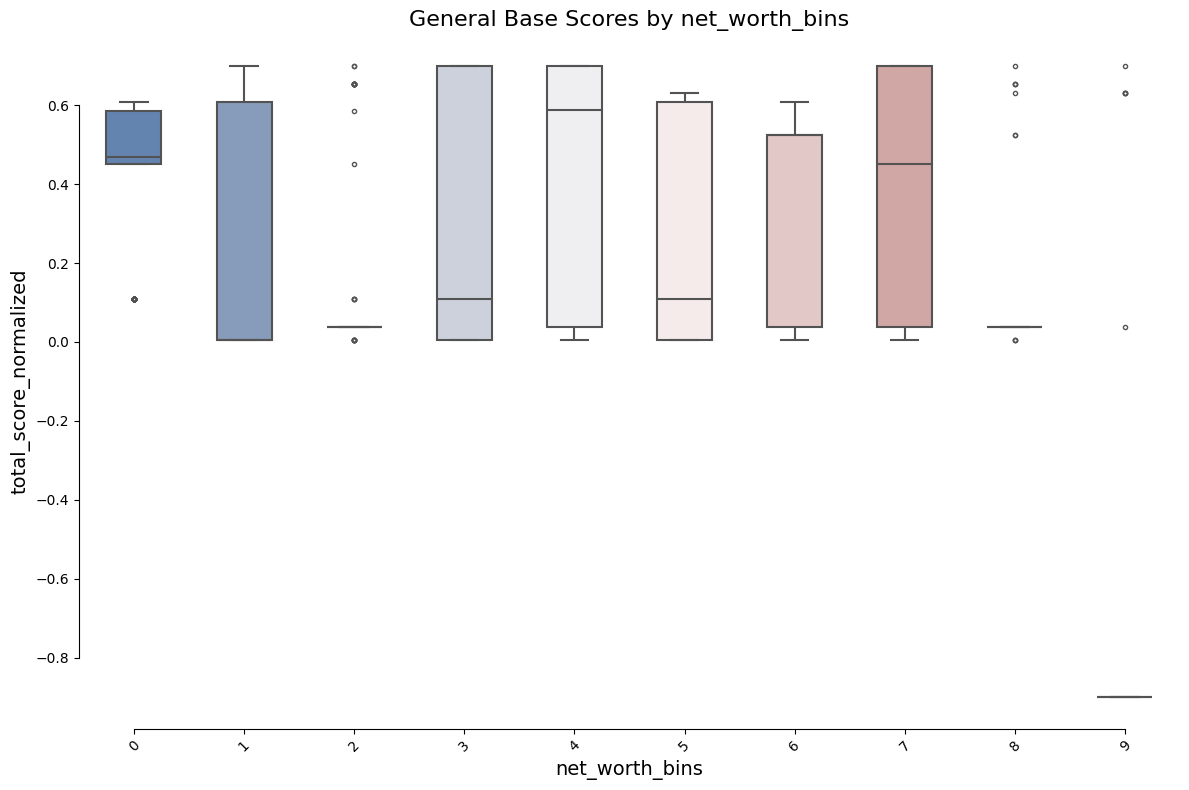

/var/folders/b8/ffvxv5g116l_p3gx35tljqzh0000gn/T/ipykernel_69162/3308832447.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


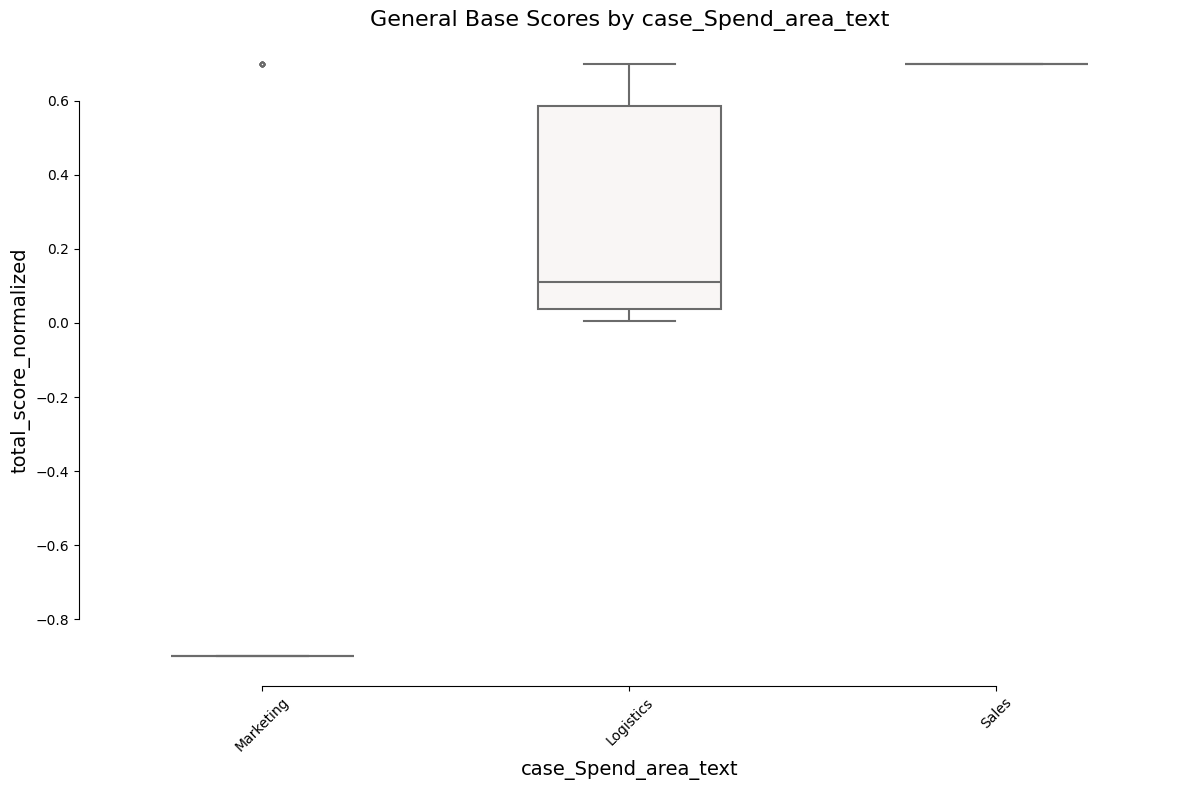

In [91]:
dict_Weights = {
"Standard": {
"basic_events": ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"],
"sequential_events": [("Create Purchase Order Item", "Vendor Creates Invoice"), ("Vendor Creates Invoice", "Record Goods Receipt"), ("Record Goods Receipt", "Clear Invoice")],
"harmon_events": ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"],
"unique_events": [ "Record Goods Receipt", "Clear Invoice"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location', 'Change Currency' ,'Change payment term'
 'Change Rejection Indicator','Change Approval for Purchase Order', 'Change Quantity', 'Change Material', 'Change Vendor', 
 'Change Purchase Order Item', 'Cancel Goods Receipt' 'Cancel Invoice Receipt'],
},
"Service": {
"basic_events": ["Create Purchase Order Item",  "Record Goods Receipt"],
"sequential_events": [("Create Purchase Order Item", "Record Goods Receipt")],
"harmon_events": ["Create Purchase Order Item", "Record Goods Receipt",],
"unique_events": ["Record Goods Receipt"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location' 'Change Currency' ],
},
"Consignment": {
"basic_events": ["Create Purchase Order Item",  "Record Goods Receipt", "Record Service Entry Sheet"],
"sequential_events": [("Create Purchase Order Item", "Record Goods Receipt"), ("Record Goods Receipt", "Record Service Entry Sheet")],
"harmon_events": ["Create Purchase Order Item", "Record Goods Receipt"],
"unique_events": ["Record Goods Receipt"],
"avoid_events": ["Delete Purchase Order Item", "Change Price",'Change Storage Location' 'Change Currency' ],
}
,
"General": {
"basic_events": ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"],
"sequential_events": [("Create Purchase Order Item", "Vendor Creates Invoice"), ("Vendor Creates Invoice", "Record Goods Receipt"), ("Record Goods Receipt", "Clear Invoice")],
"harmon_events": ["Create Purchase Order Item", "Vendor Creates Invoice", "Record Goods Receipt", "Clear Invoice"],
"unique_events": [ "Record Goods Receipt", "Clear Invoice"],
"avoid_events": ["Change Price",'Change Storage Location', 'Change Currency'  'Change Quantity', 'Change Material', 'Change Vendor'],
}
}

def create_score_data(data, norm_dict=dict_Weights["General"], index_column='case_Purchasing_Document', plot=False):
    """
    Create a DataFrame with scores for each case_Purchasing_Document based on the specified norms.
    
    Parameters:
    - data: DataFrame containing the dataset.
    - norm_dict: Dictionary containing the norms and corresponding event lists.
    - index_column: The column to use as the pivot table index.
    
    Returns:
    - score_data: DataFrame with scores for each case_Purchasing_Document.
    """
    
    columns_basic = norm_dict["basic_events"]
    columns_avoid = norm_dict["avoid_events"]
    
    pivot_table_basic = create_pivot(data, index_column='case_Purchasing_Document', columns=columns_basic)
    pivot_table_avoid = create_pivot(data, index_column='case_Purchasing_Document', columns=columns_avoid)
    
    pivot_table_basic = calculate_scores_basic(pivot_table_basic, column_name='Create Purchase Order Item', power_calc=True, power=4)
    pivot_table_avoid = calculate_scores_avoid(pivot_table_avoid)
    
    score_data = add_scores_to_log(data, pivot_table_basic[['score_basic']], score_column_name='score_basic', merge_on='case_Purchasing_Document')
    score_data = add_scores_to_log(score_data, pivot_table_avoid[['score_avoid']], score_column_name='score_avoid', merge_on='case_Purchasing_Document')
    
    score_data = get_total_score(score_data, score_columns=['score_basic', 'score_avoid'], weights=[0.7, 0.3])
    
    if plot:
        plot_scores_boxplot(score_data, 'total_score_normalized', index_column, title=f'General Base Scores by {index_column}')
    
    return score_data


#create bins based on event_Cumulative_net_worth_(EUR)	, create 10 bins, name bins based on the value of the bin
full_log['net_worth_bins'] = pd.qcut(full_log['event_Cumulative_net_worth_(EUR)'], q=10, labels=False)

#get only service data 
service_log = full_log[full_log['case_Item_Type'] == 'Service']
#service_log['net_worth_bins'] = pd.qcut(service_log['event_Cumulative_net_worth_(EUR)'], q=5, labels=False)

columns = ['case_Sub_spend_area_text', 'case_Document_Type' ,'case_Vendor', 'net_worth_bins','case_Spend_area_text']


for column in columns:
    service_data = create_score_data(service_log, index_column=column, norm_dict=dict_Weights["Service"], plot=True)


In [78]:
service_log.sample(5).head(5)

eventID case_Spend_area_text    case_Company case_Document_Type  \
149      536870912264            Marketing  companyID_0000  EC Purchase order   
173      536870912140            Marketing  companyID_0000  EC Purchase order   
5830  935138934390788                Sales  companyID_0000        Standard PO   
2987  447127570350146            Logistics  companyID_0000        Standard PO   
23       536870912304            Marketing  companyID_0000  EC Purchase order   

      case_Sub_spend_area_text  case_Purchasing_Document  \
149          Digital Marketing                2000000100   
173          Digital Marketing                2000000100   
5830       Products for Resale                4508065933   
2987  Other Logistics Services                4507030736   
23           Digital Marketing                2000000100   

     case_Purch._Doc._Category_name    case_Vendor case_Item_Type  \
149                  Purchase order  vendorID_0053        Service   
173                  Purchase order  vendorID_0053        Service   
5830                 Purchase order  vendorID_0404        Service   
2987                 Purchase order  vendorID_0230        Service   
23                   Purchase order  vendorID_0053        Service   

                 case_Item_Category case_Spend_classification_text  \
149   3-way match, invoice after GR                            NPR   
173   3-way match, invoice after GR                            NPR   
5830  3-way match, invoice after GR                            NPR   
2987  3-way match, invoice after GR                            NPR   
23    3-way match, invoice after GR                            NPR   

              case_Source    case_Name  case_GR-Based_Inv._Verif.  case_Item  \
149   sourceSystemID_0000  vendor_0053                       True          1   
173   sourceSystemID_0000  vendor_0053                       True          1   
5830  sourceSystemID_0000  vendor_0393                       True        110   
2987  sourceSystemID_0000  vendor_0225                       True          1   
23    sourceSystemID_0000  vendor_0053                       True          1   

     case_concept_name  case_Goods_Receipt event_User event_org_resource  \
149   2000000100_00001                True   user_013           user_013   
173   2000000100_00001                True   user_000           user_000   
5830  4508065933_00110                True   user_020           user_020   
2987  4507030736_00001                True       NONE               NONE   
23    2000000100_00001                True   user_019           user_019   

              event_concept_name  event_Cumulative_net_worth_(EUR)  \
149       Record Invoice Receipt                         7815013.0   
173         Record Goods Receipt                         7815013.0   
5830      Record Invoice Receipt                             348.0   
2987  Record Service Entry Sheet                              59.0   
23        Record Invoice Receipt                         7815013.0   

          event_time_timestamp  @@index  @@case_index case:concept:name  \
149  2018-06-09 14:04:00+00:00      149             0  2000000100_00001   
173  2018-06-27 01:20:00+00:00      173             0  2000000100_00001   
5830 2019-03-01 12:21:00+00:00     5830           866  4508065933_00110   
2987 2018-05-22 22:44:00+00:00     2987           416  4507030736_00001   
23   2018-02-10 12:31:00+00:00       23             0  2000000100_00001   

                    concept:name            time:timestamp  
149       Record Invoice Receipt 2018-06-09 14:04:00+00:00  
173         Record Goods Receipt 2018-06-27 01:20:00+00:00  
5830      Record Invoice Receipt 2019-03-01 12:21:00+00:00  
2987  Record Service Entry Sheet 2018-05-22 22:44:00+00:00  
23        Record Invoice Receipt 2018-02-10 12:31:00+00:00

In [35]:
#iterate over full_log and for each distint case_Item_Type get top 3 variants of eventlog with pm4py and visualise them
for i in full_log['case_Item_Type'].unique():
    print(f"Case_Item_Type: {i}")
    filtered_log = full_log[full_log['case_Item_Type'] == i]
    try:
        weights = dict_Weights[i]
        print(f"Weights: {weights}")
    except KeyError:
        print(f"No weights for {i}")
        continue

    pivot_table = create_pivot(filtered_log, index_column='case_Purchasing_Document', columns=weights['basic_events'])
    #calculate scores for each row in the pivot table
    pivot_table = calculate_scores_harmonization(pivot_table, column_name='Create Purchase Order Item', power_calc=True, power=4)
    filtered_log_with_scores = add_scores_to_log(filtered_log, pivot_table[['score']], score_column_name='score', merge_on='case_Purchasing_Document')

    #sort pivot table by scores desc
    #pivot_table = pivot_table.sort_values(by='score', ascending=False)
    #save pivot_table to csv in folder 'C:\Code\Github\WISE\wise_flow\tests\data\pivot_tables'
    #pivot_table.to_csv(f'C:\Code\Github\WISE\wise_flow\\tests\data\pivot_tables\{i}_harmon.csv')
    #plot_scores_boxplot(filtered_log, pivot_table, 'score', 'case_Spend_area_text')
    plot_custom_boxplot(filtered_log_with_scores, 'score', 'case_Spend_area_text')
    #create log with top 30 case_Vendor (based on count of case_Purchasing_Document) and other to 'Other' add column top_vendor
    top_vendors = filtered_log_with_scores['case_Vendor'].value_counts().head(20).index
    filtered_log_with_scores['top_vendor'] = filtered_log['case_Vendor'].apply(lambda x: x if x in top_vendors else 'Other')
    plot_custom_boxplot(filtered_log_with_scores, 'score', 'top_vendor')



Case_Item_Type: Service
Weights: {'basic_events': ['Create Purchase Order Item', 'Record Goods Receipt'], 'sequential_events': [('Create Purchase Order Item', 'Record Goods Receipt')], 'harmon_events': ['Create Purchase Order Item', 'Record Goods Receipt'], 'unique_events': ['Record Goods Receipt'], 'avoid_events': ['Delete Purchase Order Item', 'Change Price', 'Change Storage LocationChange Currency']}


KeyError: "None of [Index(['score'], dtype='object', name='event_concept_name')] are in the [columns]"

Case_Item_Type: Standard
Activities for Standard: event_concept_name
Record Goods Receipt                   222656
Create Purchase Order Item             220186
Record Invoice Receipt                 209758
Vendor creates invoice                 204459
Clear Invoice                          181473
Remove Payment Block                    55181
Create Purchase Requisition Item        42567
Receive Order Confirmation              31324
Change Quantity                         17603
Change Price                            10685
Delete Purchase Order Item               7853
Cancel Invoice Receipt                   6254
Vendor creates debit memo                5508
Change Approval for Purchase Order       3463
Change Delivery Indicator                2697
Cancel Goods Receipt                     1969
Release Purchase Order                   1448
SRM: In Transfer to Execution Syst.       994
SRM: Created                              976
SRM: Document Completed                   976
SRM: Awaiti

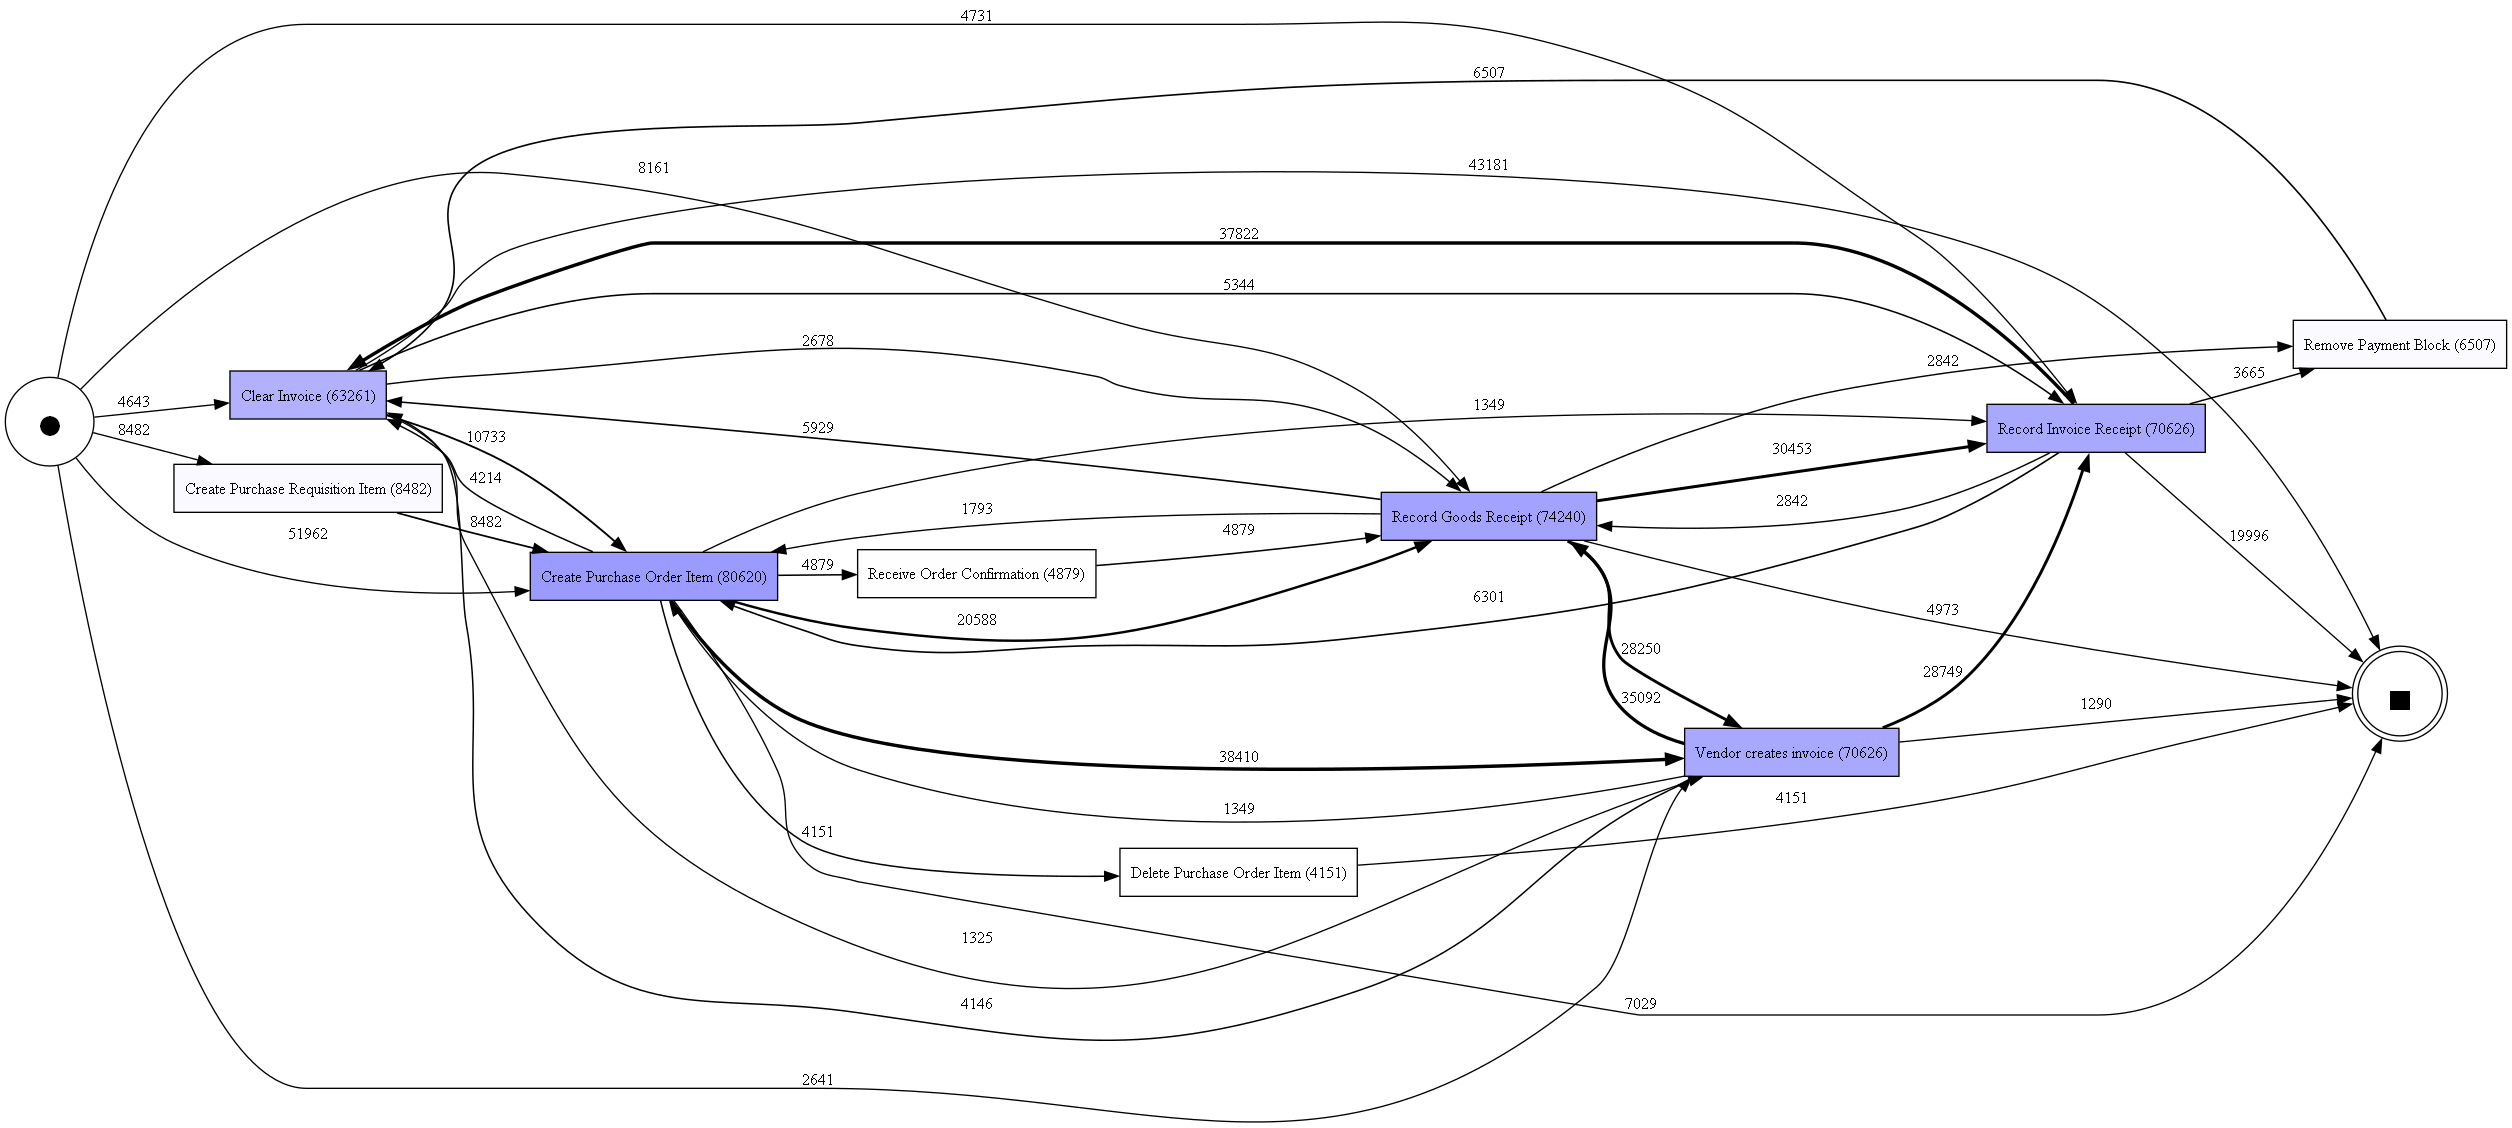

Case_Item_Type: Service
Activities for Service: event_concept_name
Record Service Entry Sheet             164975
Record Goods Receipt                    65631
Record Invoice Receipt                   9967
Vendor creates invoice                   7580
Clear Invoice                            6013
Create Purchase Order Item               5838
Cancel Goods Receipt                      888
SRM: In Transfer to Execution Syst.       771
SRM: Awaiting Approval                    652
SRM: Complete                             652
SRM: Document Completed                   652
SRM: Ordered                              652
SRM: Created                              652
Remove Payment Block                      608
SRM: Change was Transmitted               497
Cancel Invoice Receipt                    436
Change Price                              397
Vendor creates debit memo                 367
SRM: Deleted                              155
Set Payment Block                          61
Delete Purcha

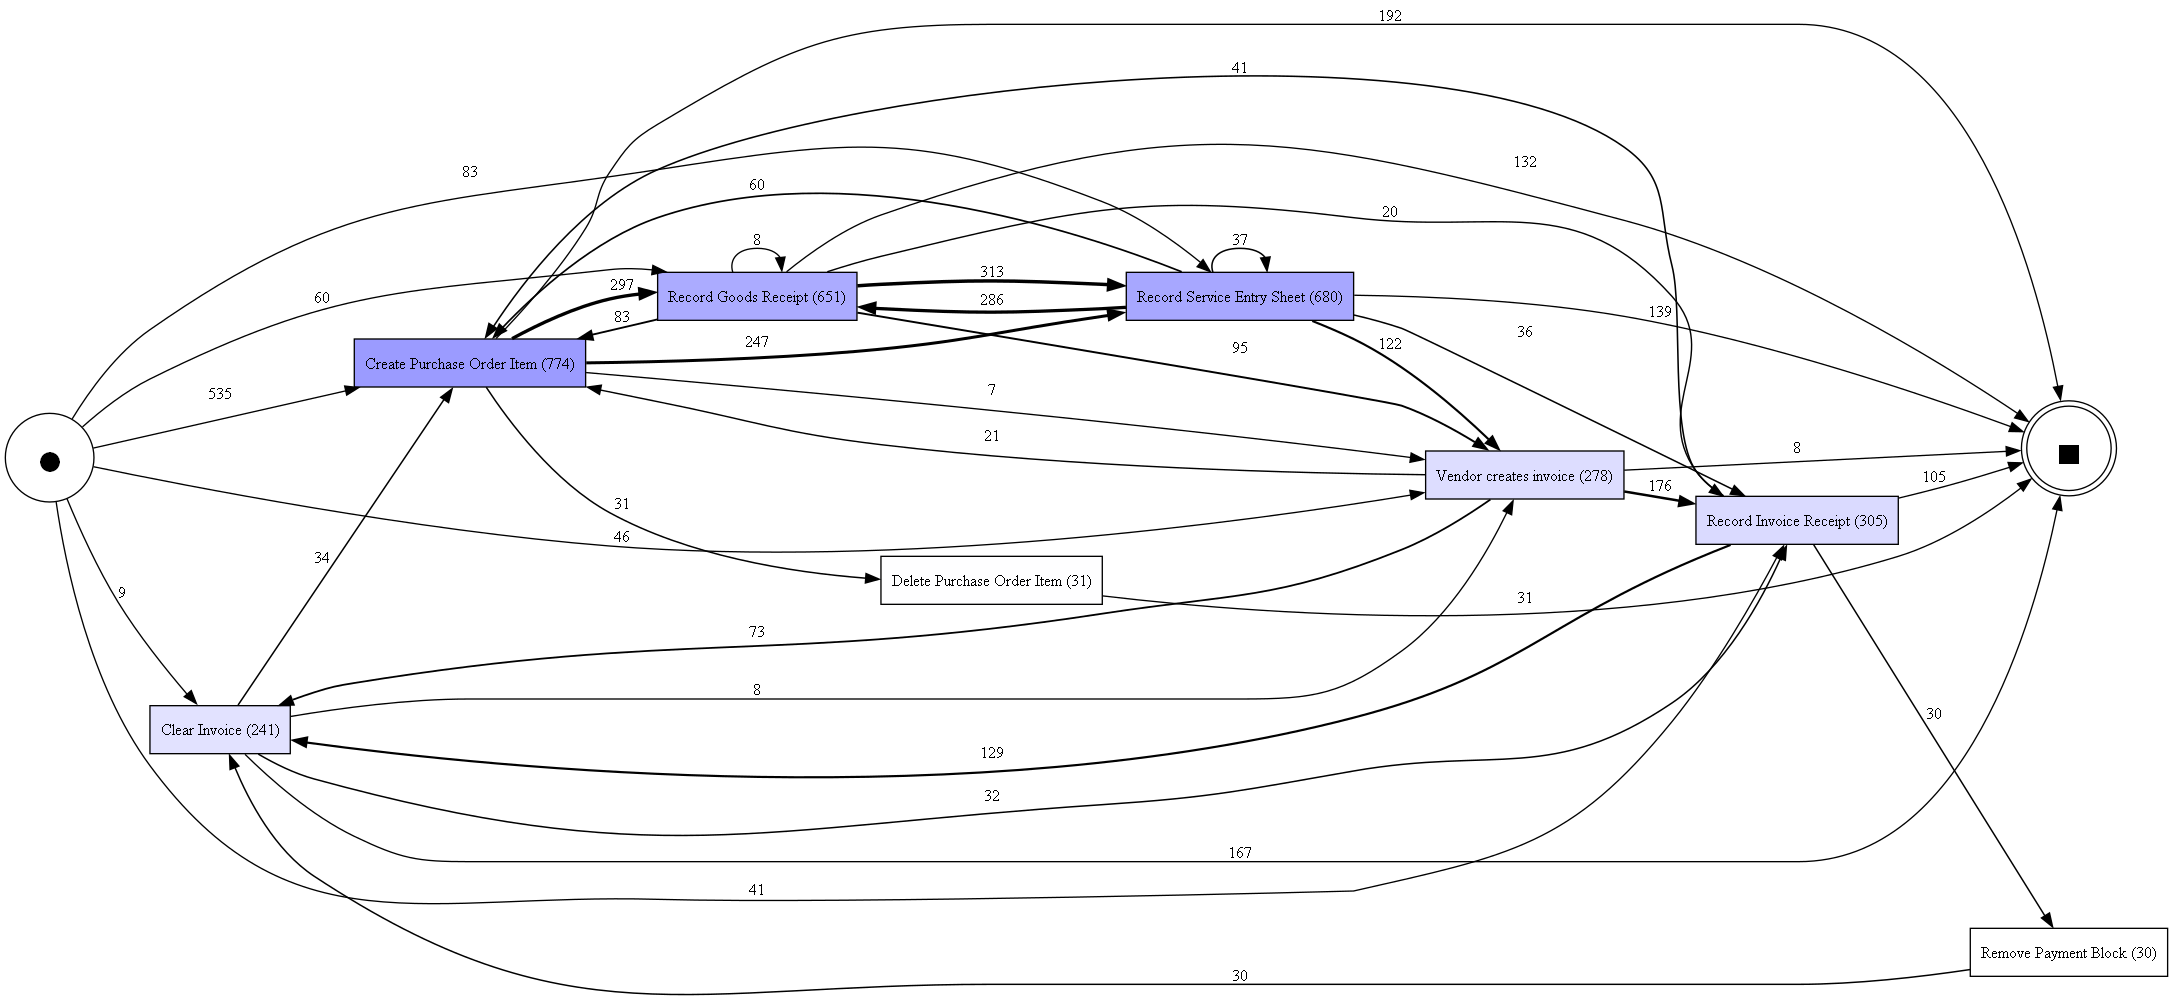

Case_Item_Type: Consignment
Activities for Consignment: event_concept_name
Record Goods Receipt                15459
Create Purchase Order Item          14498
Create Purchase Requisition Item     2800
Change Quantity                      1343
Receive Order Confirmation            741
Change Delivery Indicator             506
Delete Purchase Order Item            425
Cancel Goods Receipt                  219
Change Price                           42
Change Storage Location                18
Reactivate Purchase Order Item         11
Update Order Confirmation              10
Release Purchase Requisition           10
Change payment term                     1
Change Currency                         1
Name: count, dtype: int64
Number of traces: 30266
-----------------



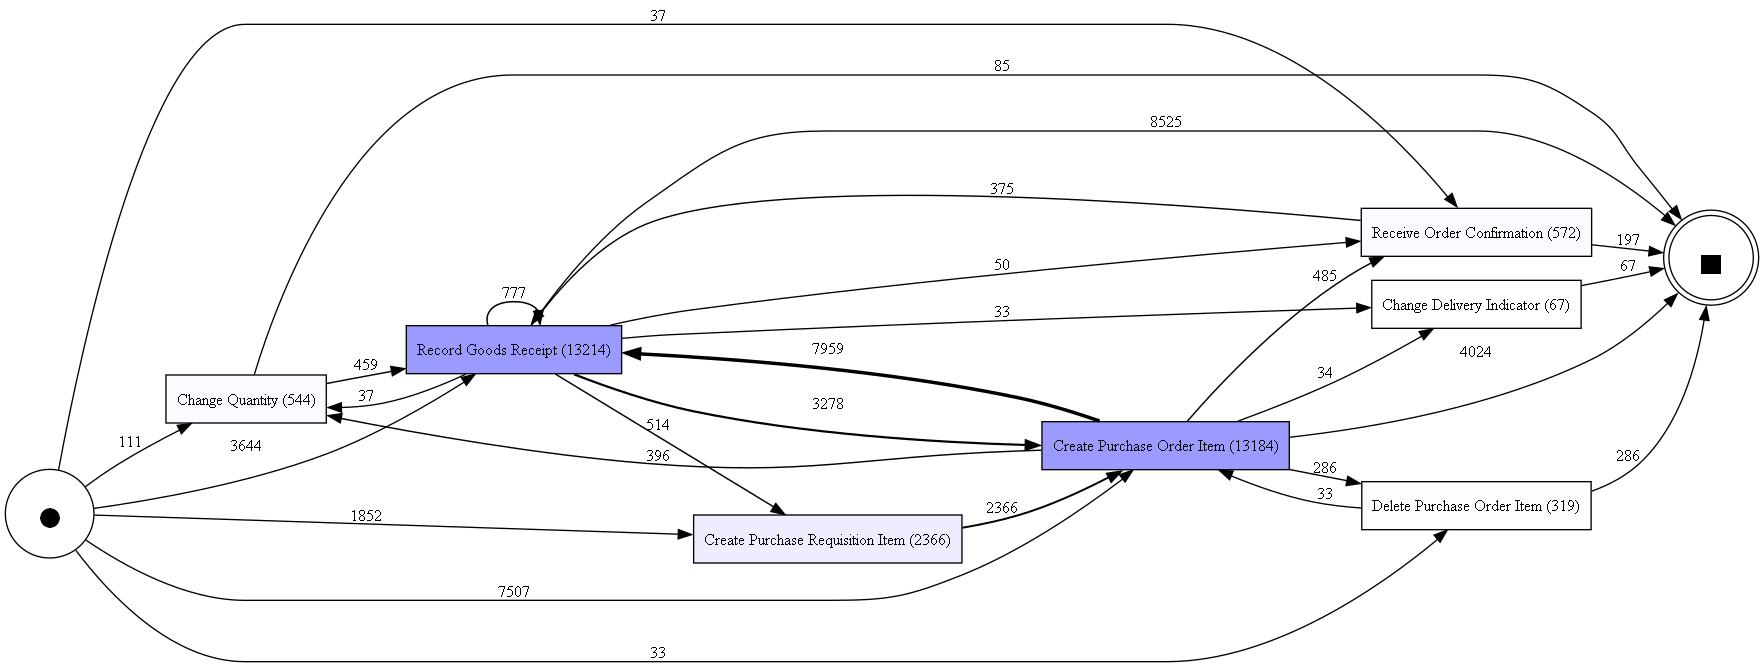

Case_Item_Type: Subcontracting
Activities for Subcontracting: event_concept_name
Record Goods Receipt                  5004
Create Purchase Order Item            4678
Record Invoice Receipt                2812
Change Quantity                       2465
Vendor creates invoice                2063
Clear Invoice                         1835
Change Price                           968
Change Approval for Purchase Order     967
Remove Payment Block                   343
Delete Purchase Order Item             342
Create Purchase Requisition Item       253
Release Purchase Order                 162
Cancel Invoice Receipt                 155
Reactivate Purchase Order Item         138
Block Purchase Order Item              129
Vendor creates debit memo              126
Change Delivery Indicator               62
Change Storage Location                 22
Cancel Goods Receipt                    10
Name: count, dtype: int64
Number of traces: 8009
-----------------



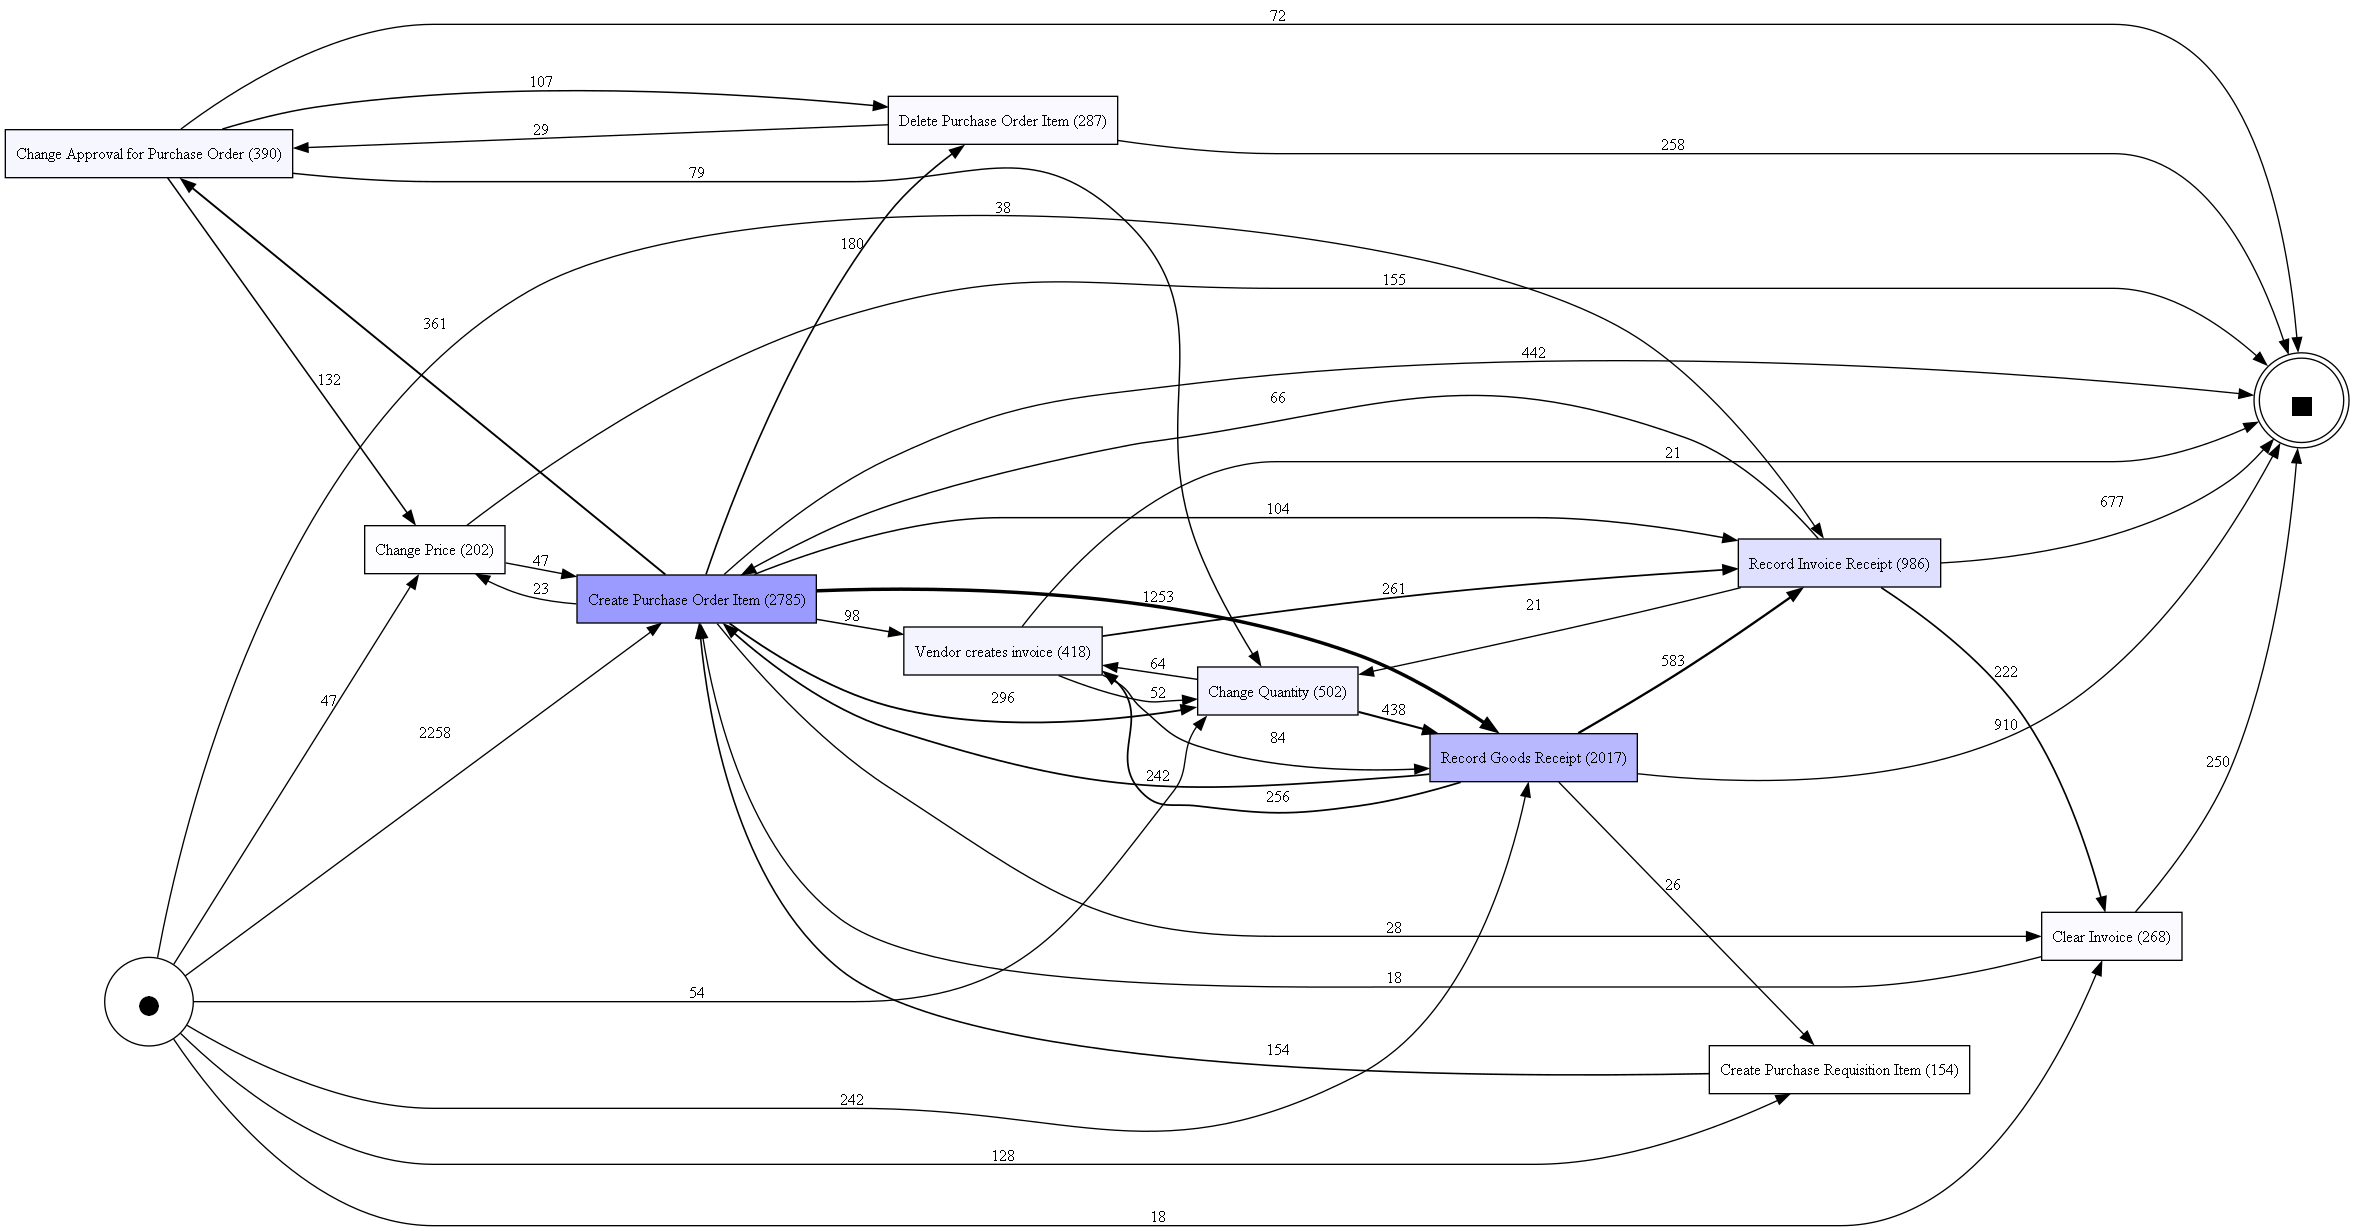

Case_Item_Type: Third-party
Activities for Third-party: event_concept_name
Record Invoice Receipt              5528
Create Purchase Order Item          5490
Record Goods Receipt                5347
Vendor creates invoice              5128
Clear Invoice                       4765
Remove Payment Block                1003
Create Purchase Requisition Item     972
Change Price                         320
Vendor creates debit memo            244
Cancel Invoice Receipt               241
Delete Purchase Order Item           189
Change Quantity                       38
Cancel Subsequent Invoice             17
Reactivate Purchase Order Item        11
Cancel Goods Receipt                  10
Record Subsequent Invoice              7
Change Delivery Indicator              6
Name: count, dtype: int64
Number of traces: 15892
-----------------



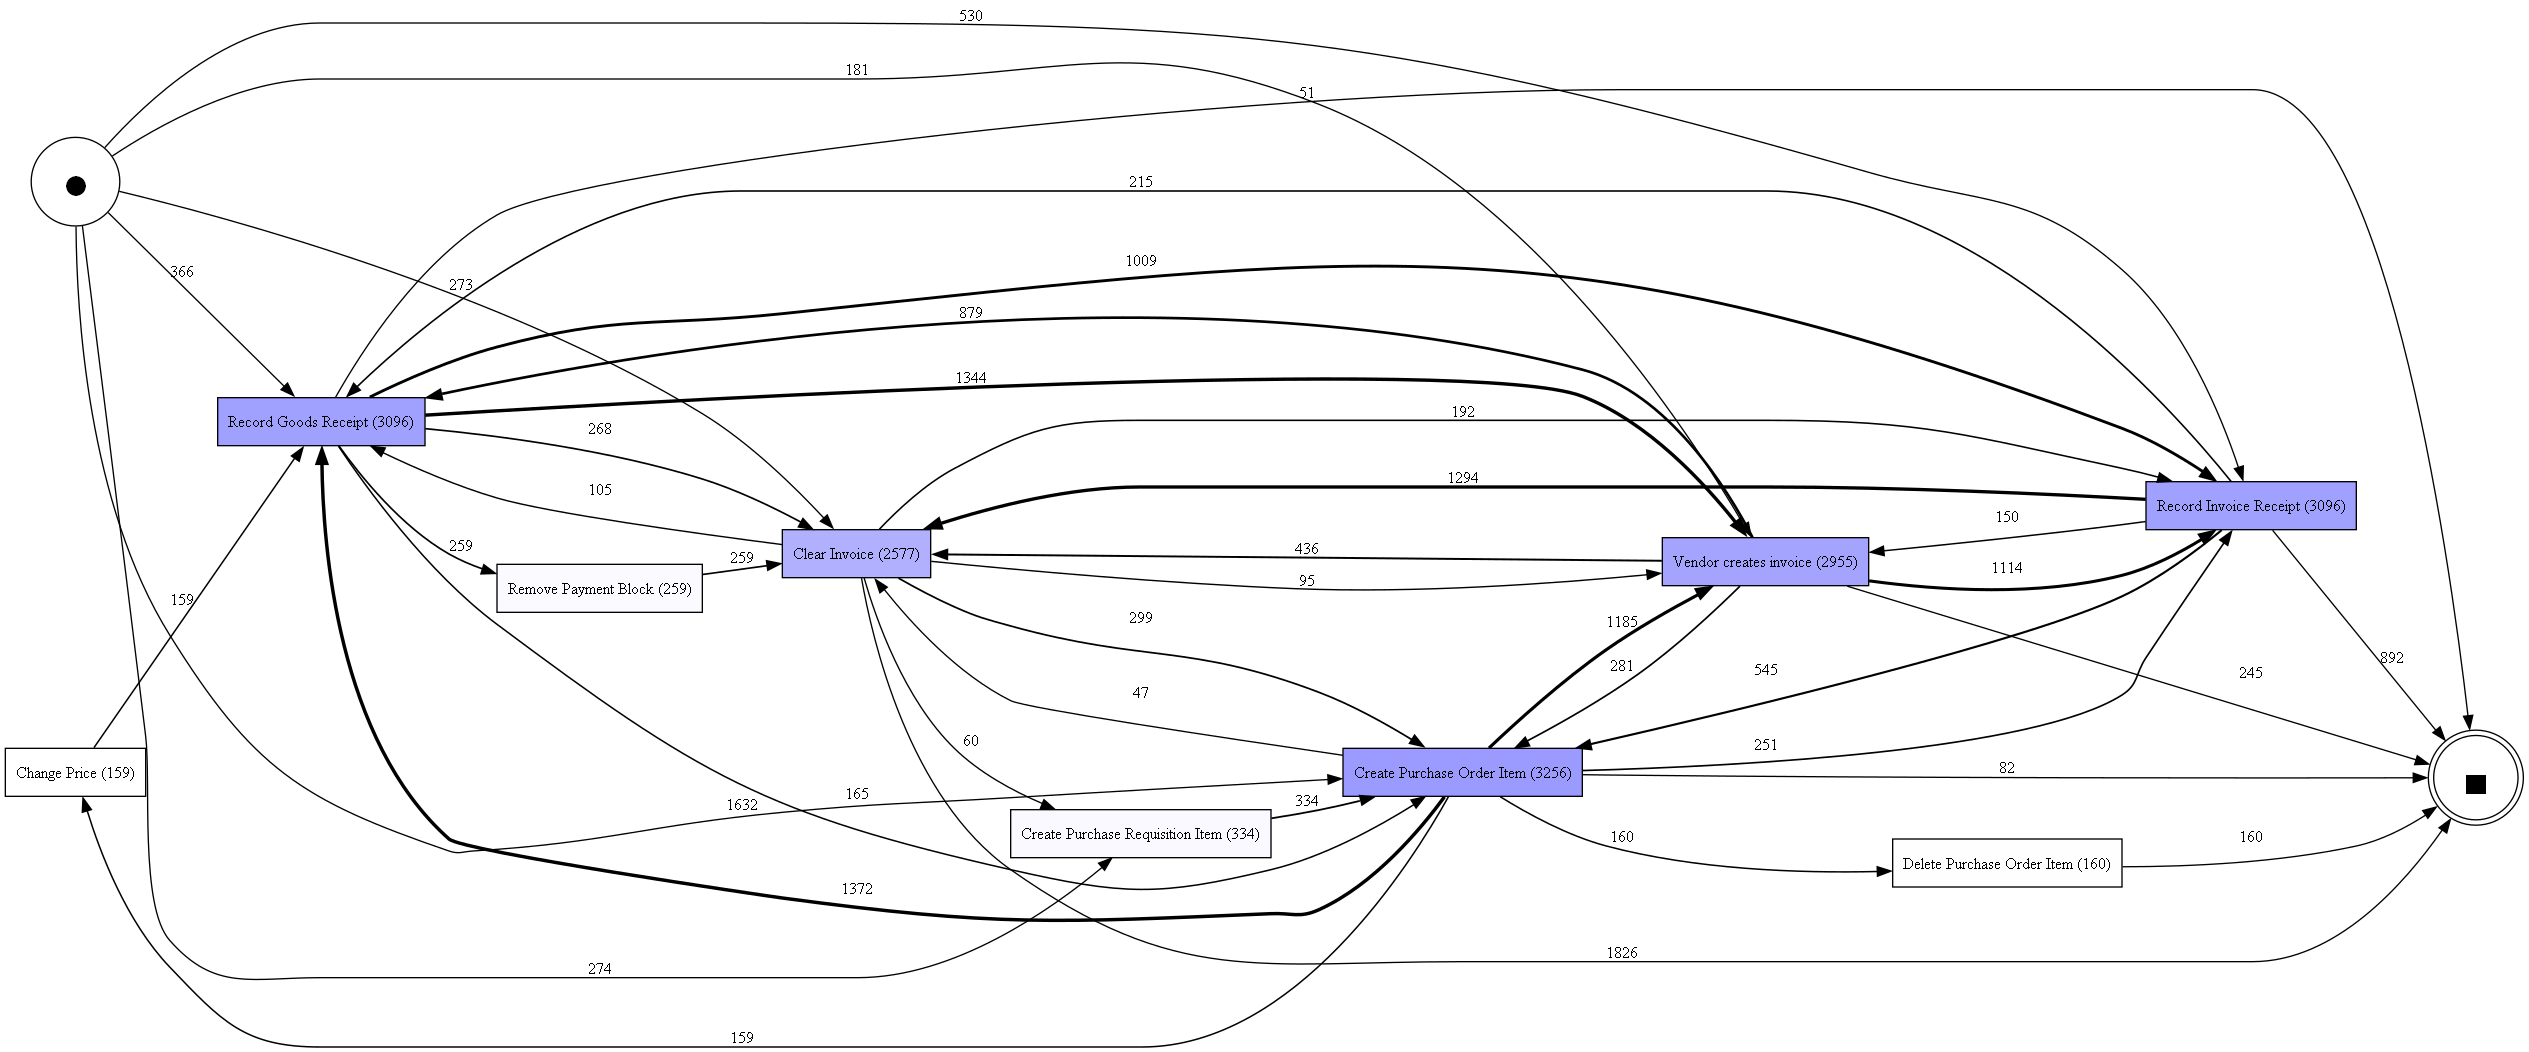

Case_Item_Type: Limit
Activities for Limit: event_concept_name
Change Approval for Purchase Order    3111
Create Purchase Order Item            1044
Record Invoice Receipt                 695
Vendor creates invoice                 689
Clear Invoice                          307
Change Price                            11
Set Payment Block                       11
Vendor creates debit memo               10
Cancel Invoice Receipt                  10
Delete Purchase Order Item               9
Remove Payment Block                     1
Name: count, dtype: int64
Number of traces: 3127
-----------------



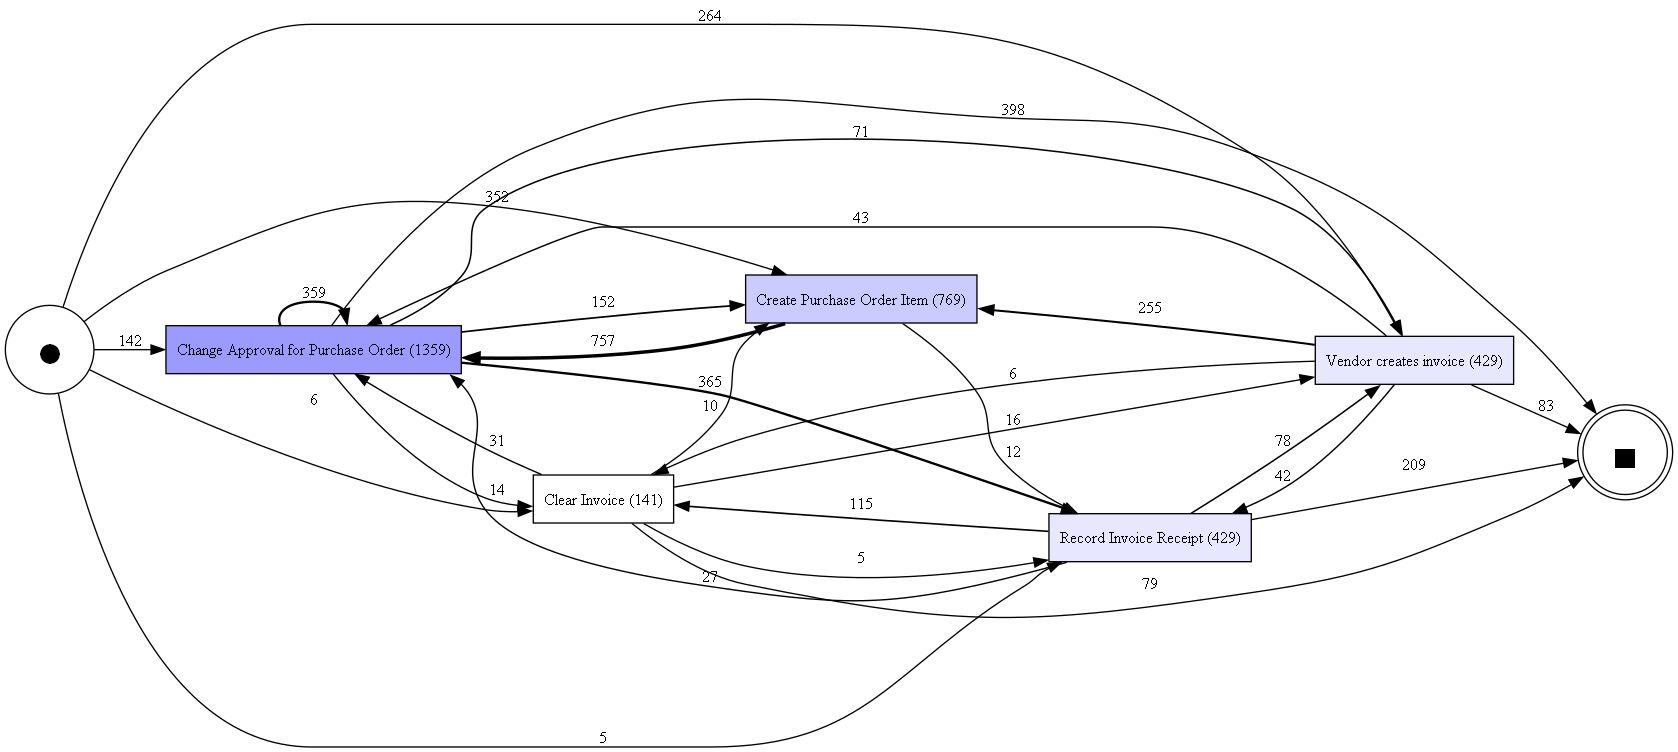

In [ ]:
#iterate over full_log and for each distint case_Item_Type get top 3 variants of eventlog with pm4py and visualise them
for i in full_log['case_Item_Type'].unique():
    print(f"Case_Item_Type: {i}")
    filtered_log = full_log[full_log['case_Item_Type'] == i]
    print(f"Activities for {i}: {filtered_log['event_concept_name'].value_counts()}")
    filtered_log = pm4py.filter_variants_top_k(filtered_log, k=30)
    filtered_log.to_csv(f"C:\Code\Github\WISE\wise_flow\\tests\data\BPI_Challenge_2019_sample_{i}.csv")
    pivot_by_document = create_pivot(filtered_log, 'case_Purchasing_Document')
    #save pivot_by_document to csv
    pivot_by_document.to_csv(f'C:\Code\Github\WISE\wise_flow\\tests\data\pivot_by_document_Item_{i}.csv')
    print(f"Number of traces: {len(filtered_log)}")
    print("-----------------\n")
    dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_log, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
    pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
import pandas as pd

def create_pivot(data, index_column, values_column='event_concept_name'):
    """
    Creates a pivot table that counts occurrences of distinct values in the values_column
    for each unique value in the index_column.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - index_column: The column to group by and display in the pivot table's index.
    - values_column: The column for which to count distinct values (default 'event_concept_name').

    Returns:
    - pivot_table: A pandas DataFrame representing the pivot table.
    """
    # Create pivot table with counts of each 'event_concept_name' for the specified 'index_column'
    pivot_table = pd.pivot_table(data, index=index_column, columns=values_column, aggfunc='size', fill_value=0)
    
    return pivot_table

standard_log = full_log[full_log['case_Item_Type'] == i]
pivot_by_document = create_pivot(standard_log, 'case_Purchasing_Document')
#save pivot_by_document to csv
pivot_by_document.to_csv('C:\Code\Github\WISE\wise_flow\\tests\data\pivot_by_document_Item_Standard.csv')

#pivot_by_document = create_pivot(analyse_log, 'case_Purchasing_Document')
#print(pivot_by_document)

#pivot_by_concept_name = create_pivot(analyse_log, 'case_concept_name')
#print(pivot_by_concept_name)

18
1
1
1


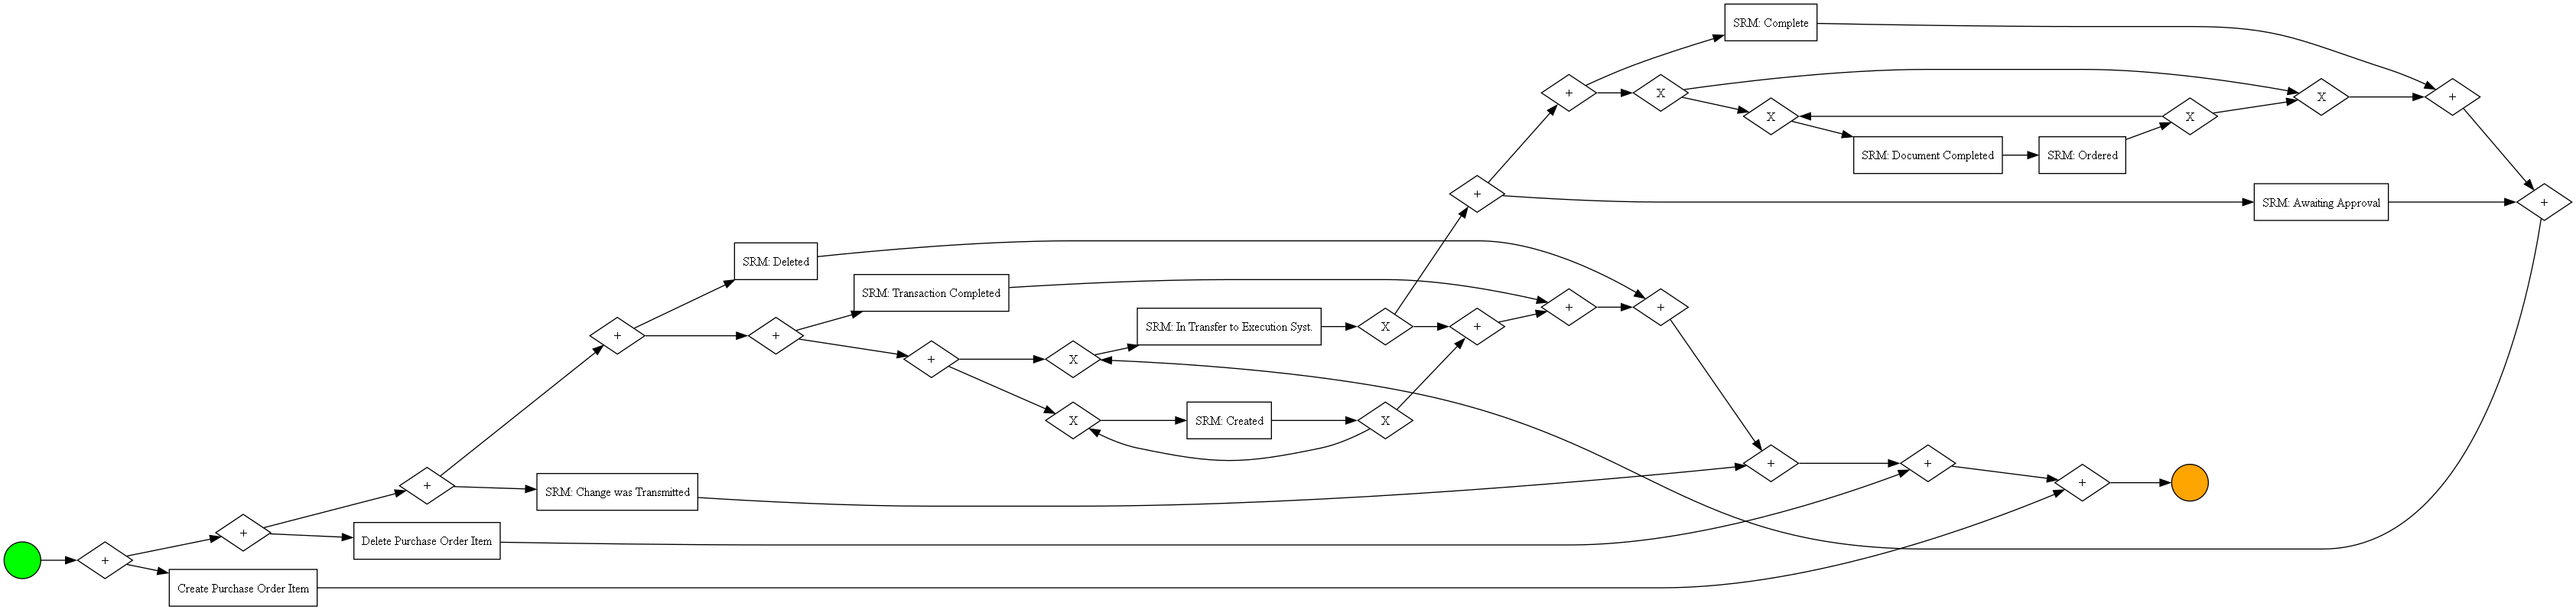

c:\Users\jessen_u\AppData\Local\miniconda3\envs\WISE\Lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


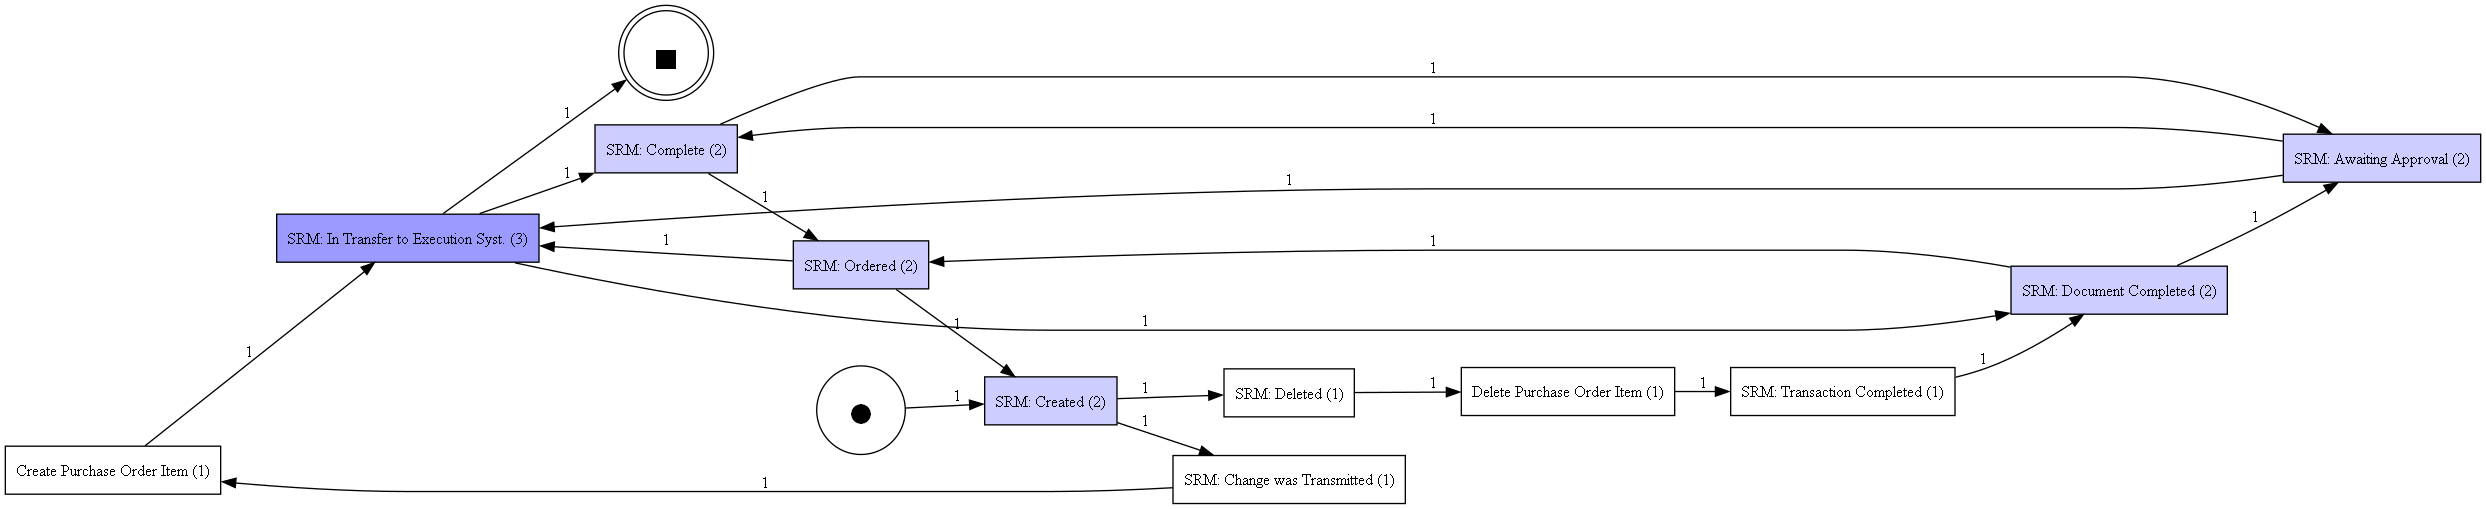

SRM: Created 43.0
SRM: Change was Transmitted 43.0
Create Purchase Order Item 43.0
SRM: In Transfer to Execution Syst. 43.0
SRM: Document Completed 43.0
SRM: Awaiting Approval 43.0
SRM: Complete 43.0
SRM: Ordered 43.0
SRM: Deleted 43.0
Delete Purchase Order Item 43.0
SRM: Transaction Completed 43.0


In [ ]:
def sum_unique(log, event_name, unique_column, sum_column):
    """
    Sum values in sum_column based on uniqueness in unique_column.

    Parameters
    - log: pm4py event log.
    - event_name: The name of the event to filter on.
    - unique_column: The column in data on which to determine uniqueness.
    - sum_column: The column in data whose values are to be summed.

    Returns:
    - The sum of values in sum_column for unique values in unique_column,
      considering only the first occurrence of each unique value in unique_column.
    """
    data = log[log['event_concept_name'] == event_name]
    # Drop duplicates based on the unique_column, keeping the first occurrence
    unique_data = data.drop_duplicates(subset=[unique_column])
    
    # Sum the values in the sum_column for the filtered unique_data
    total_sum = unique_data[sum_column].sum()
    
    return total_sum


def vis_po(log, po_number,vis=True, save_log=False, print_sum=False):
    sing_log = log[log['case_Purchasing_Document'] == po_number]
    if save_log:
        print(len(sing_log))
        #count number unique values of case_concept_name
        print(sing_log['case_concept_name'].nunique())
        print(sing_log['case_Goods_Receipt'].nunique())
        print(sing_log['case_Item'].nunique())
        sing_log.to_csv(f'C:\Code\Github\WISE\wise_flow\\tests\data\po_{po_number}.csv')
    if vis:
        bpmn_graph = pm4py.discover_bpmn_inductive(sing_log, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
        pm4py.view_bpmn(bpmn_graph)
        dfg, start_activities, end_activities = pm4py.discover_dfg(sing_log, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
        pm4py.view_dfg(dfg, start_activities, end_activities)
    if print_sum:
        #iterate over all unique values of case_concept_name and sum the values 
        for i in sing_log['event_concept_name'].unique():
            print(i, sum_unique(sing_log, i, 'case_concept_name', 'event_Cumulative_net_worth_(EUR)'))
    return sing_log

analyse_log = vis_po(full_log, 2000000053, vis=True, save_log=True, print_sum=True)

#4507023323 33 PO and 33 Invoices
#4507017521 bad ???
#4508059728 1 PO 66 Service Entry Sheets 61 Goods Receipt
#4508062060 service Entry sheets
#4508073957  1 PO 5 Goods Receipt 31 Service Entry Sheets
#2000000053


In [ ]:
full_log.case_Item_Type.value_counts()

case_Item_Type
Standard          1234490
Service            267601
Consignment         36084
Third-party         29316
Subcontracting      22534
Limit                5898
Name: count, dtype: int64

In [ ]:
import pandas as pd

def create_pivot(data, index_column, values_column='event_concept_name'):
    """
    Creates a pivot table that counts occurrences of distinct values in the values_column
    for each unique value in the index_column.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - index_column: The column to group by and display in the pivot table's index.
    - values_column: The column for which to count distinct values (default 'event_concept_name').

    Returns:
    - pivot_table: A pandas DataFrame representing the pivot table.
    """
    # Create pivot table with counts of each 'event_concept_name' for the specified 'index_column'
    pivot_table = pd.pivot_table(data, index=index_column, columns=values_column, aggfunc='size', fill_value=0)
    
    return pivot_table

pivot_by_document = create_pivot(log, 'case_Purchasing_Document')
#save pivot_by_document to csv
pivot_by_document.to_csv('C:\Code\Github\WISE\wise_flow\\tests\data\pivot_by_document.csv')

#pivot_by_document = create_pivot(analyse_log, 'case_Purchasing_Document')
#print(pivot_by_document)

#pivot_by_concept_name = create_pivot(analyse_log, 'case_concept_name')
#print(pivot_by_concept_name)


In [ ]:
pivot_by_document = create_pivot(log, 'case_Purchasing_Document')
#save pivot_by_document to csv
pivot_by_document.to_csv('C:\Code\Github\WISE\wise_flow\\tests\data\pivot_by_document.csv')

In [ ]:

def sum_unique(log, event_name, unique_column='case_Item', sum_column='event_Cumulative_net_worth_(EUR)'):
    """
    Sum values in sum_column based on uniqueness in unique_column.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - unique_column: The column in data on which to determine uniqueness.
    - sum_column: The column in data whose values are to be summed.

    Returns:
    - The sum of values in sum_column for unique values in unique_column,
      considering only the first occurrence of each unique value in unique_column.
    """
    data = log[log['concept:name'] == event_name]
    # Drop duplicates based on the unique_column, keeping the first occurrence
    unique_data = data.drop_duplicates(subset=[unique_column])
    
    # Sum the values in the sum_column for the filtered unique_data
    total_sum = unique_data[sum_column].sum()
    
    return total_sum

print(f"Sum of 'Record Goods Receipt' events: {sum_unique(analyse_log, 'Record Goods Receipt' )}")
get_number_events(analyse_log, 'Record Goods Receipt')

Sum of 'Record Goods Receipt' events: 1799.0


NameError: name 'get_number_events' is not defined

In [ ]:
#save analyse_log to csv
analyse_log.to_csv('C:\Code\Github\WISE\wise_flow\\tests\data\\singular_log.csv', index=False)
gr = analyse_log[analyse_log['concept:name'] == 'Record Goods Receipt']
gr_columns = ['case:concept:name','case_Item', 'event_Cumulative_net_worth_(EUR)']
gr = gr[gr_columns]
gr.to_csv('C:\Code\Github\WISE\wise_flow\\tests\data\\singular_log_gr.csv', index=False)

In [ ]:
filtered_log = pm4py.filter_start_activities(log, {'SRM: Created'})
filtered_log = pm4py.filter_end_activities(filtered_log, {'Cancel Goods Receipt'})

print(f"Filtered log: {filtered_log} \n")

Filtered log:              eventID case_Spend_area_text    case_Company case_Document_Type  \
464  188007898415104            Marketing  companyID_0000  EC Purchase order   
465  188007898415108            Marketing  companyID_0000  EC Purchase order   
466  188007898415105            Marketing  companyID_0000  EC Purchase order   
467  188007898415109            Marketing  companyID_0000  EC Purchase order   
468  188007898415111            Marketing  companyID_0000  EC Purchase order   
469  188007898415106            Marketing  companyID_0000  EC Purchase order   
470  188007898415107            Marketing  companyID_0000  EC Purchase order   
471  188007898415110            Marketing  companyID_0000  EC Purchase order   
472  188007898415112            Marketing  companyID_0000  EC Purchase order   
473  188007898415113            Marketing  companyID_0000  EC Purchase order   
474  188007898415114            Marketing  companyID_0000  EC Purchase order   

    case_Sub_spend_area_t

In [ ]:
for t in log:
    print(t)
trace_log = pm4py.filter_trace(lambda x: len(x) > 15, log)
print(f"Number of traces: {len(trace_log)}")

eventID
case_Spend_area_text
case_Company
case_Document_Type
case_Sub_spend_area_text
case_Purchasing_Document
case_Purch._Doc._Category_name
case_Vendor
case_Item_Type
case_Item_Category
case_Spend_classification_text
case_Source
case_Name
case_GR-Based_Inv._Verif.
case_Item
case_concept_name
case_Goods_Receipt
event_User
event_org_resource
event_concept_name
event_Cumulative_net_worth_(EUR)
event_time_timestamp
concept:name
time:timestamp
@@index
@@case_index
case:concept:name
Number of traces: 6567


c:\Users\jessen_u\AppData\Local\miniconda3\envs\WISE\Lib\site-packages\pm4py\hof.py:66: UserWarning: input trace object is not of the appropriate type, filter() not applied
  warnings.warn('input trace object is not of the appropriate type, filter() not applied')


In [ ]:
log.head(2)

eventID case_Spend_area_text    case_Company case_Document_Type  \
0  536870912000            Marketing  companyID_0000  EC Purchase order   
1  536870912001            Marketing  companyID_0000  EC Purchase order   

  case_Sub_spend_area_text  case_Purchasing_Document  \
0        Digital Marketing                2000000100   
1        Digital Marketing                2000000100   

  case_Purch._Doc._Category_name    case_Vendor case_Item_Type  \
0                 Purchase order  vendorID_0053        Service   
1                 Purchase order  vendorID_0053        Service   

              case_Item_Category case_Spend_classification_text  \
0  3-way match, invoice after GR                            NPR   
1  3-way match, invoice after GR                            NPR   

           case_Source    case_Name  case_GR-Based_Inv._Verif.  case_Item  \
0  sourceSystemID_0000  vendor_0053                       True          1   
1  sourceSystemID_0000  vendor_0053                       True          1   

  case_concept_name  case_Goods_Receipt event_User event_org_resource  \
0  2000000100_00001                True       NONE               NONE   
1  2000000100_00001                True       NONE               NONE   

       event_concept_name  event_Cumulative_net_worth_(EUR)  \
0  Vendor creates invoice                         7815013.0   
1  Vendor creates invoice                         7815013.0   

       event_time_timestamp            concept:name            time:timestamp  \
0 2017-01-31 23:59:00+00:00  Vendor creates invoice 2017-01-31 23:59:00+00:00   
1 2017-05-25 23:59:00+00:00  Vendor creates invoice 2017-05-25 23:59:00+00:00   

   @@index  @@case_index case:concept:name  
0     4001           125  2000000100_00001  
1     4002           125  2000000100_00001

In [ ]:
# dataframe = pd.DataFrame({'event_Cumulative_net_worth_(EUR)': np.random.randint(0, 1000000, 1000)})

sns.set(style="whitegrid")

def plot_filtered_data(lower_bound, upper_bound):
    # Filter the dataframe for the selected range
    filtered_df = log[(log['event_Cumulative_net_worth_(EUR)'] >= lower_bound) & (log['event_Cumulative_net_worth_(EUR)'] <= upper_bound)]

    plt.figure(figsize=(10, 6))
    ax = sns.kdeplot(filtered_df['event_Cumulative_net_worth_(EUR)'], fill=True, bw_adjust=0.5)
    
    # Formatting for the x-axis ticks
    def format_eur(value, tick_position):
        if value >= 1e6:
            value_str = f'{value/1e6:.1f}M'
        elif value >= 1e3:
            value_str = f'{value/1e3:.1f}K'
        else:
            value_str = str(int(value))
        return value_str

    ax.xaxis.set_major_formatter(FuncFormatter(format_eur))
    
    plt.xlabel('Net Worth (EUR)')
    plt.ylabel('Density')
    plt.title('Distribution of Net Worth in Selected Range')
    plt.show()

# Widgets for selecting the data range
lower_bound_selector = widgets.IntSlider(min=0, max=500000, step=1000, value=0, description='Lower Bound (EUR):', continuous_update=False)
upper_bound_selector = widgets.IntSlider(min=0, max=500000, step=1000, value=500000, description='Upper Bound (EUR):', continuous_update=False)

interactive_plot = interactive(plot_filtered_data, lower_bound=lower_bound_selector, upper_bound=upper_bound_selector)
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='Lower Bound (EUR):', max=500000…

In [ ]:
num_cases = len(log)
num_events = sum(len(case) for case in log)
print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")

Number of cases: 6567
Number of events: 457


In [ ]:
dataframe.columns

Index(['eventID', 'case_Spend_area_text', 'case_Company', 'case_Document_Type',
       'case_Sub_spend_area_text', 'case_Purchasing_Document',
       'case_Purch._Doc._Category_name', 'case_Vendor', 'case_Item_Type',
       'case_Item_Category', 'case_Spend_classification_text', 'case_Source',
       'case_Name', 'case_GR-Based_Inv._Verif.', 'case_Item',
       'case_concept_name', 'case_Goods_Receipt', 'event_User',
       'event_org_resource', 'event_concept_name',
       'event_Cumulative_net_worth_(EUR)', 'event_time_timestamp'],
      dtype='object')

In [ ]:
dataframe.case_Item_Category.value_counts() 
dict = {'3-way match, invoice after GR':'DF1', '3-way match, invoice before GR':'DF2', '2-way match':'DF3', 'Consignment':'DF4'}
#create a new column with the description of the item category
dataframe['description'] = dataframe['case_Item_Category'].map(dict)

In [ ]:
dataframe.groupby('description')['case_concept_name'].nunique()

description
DF1     15182
DF2    221010
DF3      1044
DF4     14498
Name: case_concept_name, dtype: int64

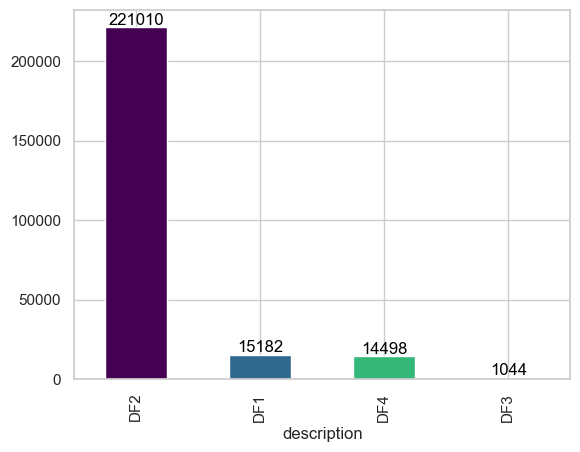

In [ ]:
def visualize_column(df, column_name, caseId=False):
    if caseId:
        # Grouping by 'case_Item_Category' and counting unique 'case_concept_name' values
        unique_counts = df.groupby(column_name)['case_concept_name'].nunique()
    else:
        # Counting the occurrences of each value in the column
        unique_counts = df[column_name].value_counts()

    # Sorting the counts for better visualization (optional)
    unique_counts_sorted = unique_counts.sort_values(ascending=False)

    # Generating a list of colors for each bar, using the number of unique groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_counts_sorted)))

    # Plotting the bar chart
    ax = unique_counts_sorted.plot(kind='bar', color=colors)

    # Adding labels on each bar
    ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', color='black')

    plt.show()

visualize_column(dataframe, 'description', caseId=True)

In [ ]:
dataframe_energy = dataframe[dataframe['case_Spend_area_text'] == 'Energy']
len(dataframe_energy.case_concept_name.unique())    

15

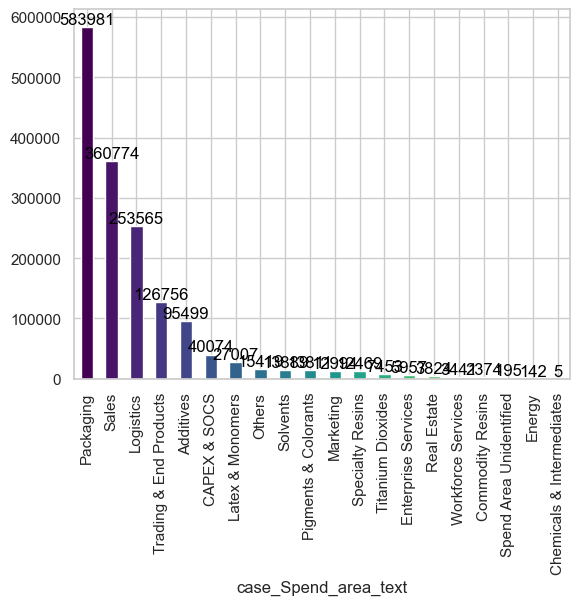

In [ ]:

visualize_column(dataframe, 'case_Spend_area_text')

In [ ]:
#print all different values of the column 'event_concept_name'
log['event_concept_name'].value_counts()

event_concept_name
Record Goods Receipt                   1382
Record Invoice Receipt                 1036
Create Purchase Order Item             1000
Vendor creates invoice                  898
Clear Invoice                           799
Record Service Entry Sheet              529
Remove Payment Block                    232
Create Purchase Requisition Item        175
Receive Order Confirmation              129
Change Quantity                          78
Change Price                             46
Cancel Invoice Receipt                   44
Change Approval for Purchase Order       40
Vendor creates debit memo                31
Delete Purchase Order Item               29
Change Delivery Indicator                15
Release Purchase Order                   14
Cancel Goods Receipt                     12
SRM: In Transfer to Execution Syst.      10
SRM: Awaiting Approval                    9
SRM: Created                              9
SRM: Ordered                              9
SRM: Document

In [ ]:
k = 2
filtered_log = pm4py.filter_variants_top_k(log, k)
print(filtered_log.case_Purchasing_Document.head(20))

705    4507002771
706    4507002771
707    4507002771
708    4507002771
709    4507002771
730    4507003227
731    4507003227
732    4507003227
733    4507003227
734    4507003227
747    4507003461
748    4507003461
749    4507003461
750    4507003461
751    4507003461
759    4507003594
760    4507003594
761    4507003594
762    4507003594
763    4507003594
Name: case_Purchasing_Document, dtype: int64


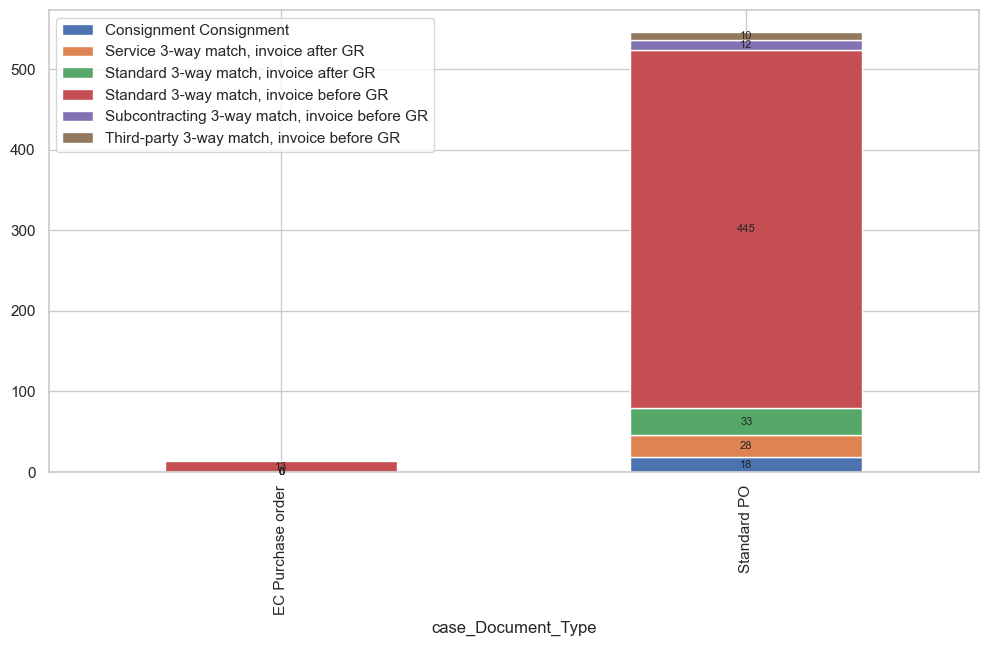

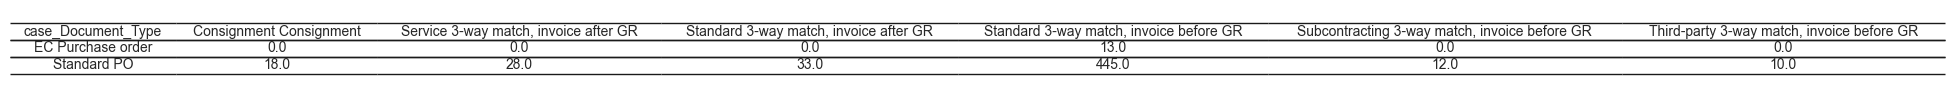

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

def create_stacked_bar_and_table(df, index_col, col1, col2):
    """
    Creates a stacked bar chart and a separate table plot.

    Parameters:
    - df: DataFrame containing the data.
    - index_col: The name of the column to be used as the index for grouping.
    - col1: The name of the first column to be used for creating subgroups.
    - col2: The name of the second column to be used for creating subgroups.
    """
    
    # Group and pivot the data
    grouped = df.groupby([index_col, col1, col2]).size().reset_index(name='count')
    pivot_df = grouped.pivot_table(index=index_col, 
                                   columns=[col1, col2], 
                                   values='count', 
                                   fill_value=0)

    # Flatten the MultiIndex columns for plotting
    pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]

    # Plot the stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot_df.plot(kind='bar', stacked=True, ax=ax)

    # Annotate bars with values
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fontsize=8)

    plt.show()

    # Create the table plot
    fig, ax = plt.subplots(figsize=(12, 0.5 * len(pivot_df)))
    ax.axis('tight')
    ax.axis('off')
    table_data = pivot_df.reset_index().values
    colLabels = pivot_df.reset_index().columns.tolist()
    table_ax = ax.table(cellText=table_data, colLabels=colLabels, loc='center', cellLoc='center', edges='horizontal')
    table_ax.auto_set_font_size(False)
    table_ax.set_fontsize(10)
    table_ax.auto_set_column_width(col=list(range(len(colLabels)))) # Provide automatic width to columns
    plt.show()

create_stacked_bar_and_table(dataframe,  'case_Document_Type', 'case_Item_Type','case_Item_Category')


In [ ]:
print(log.case_concept_name.unique())

['2000000100_00001' '2000013441_00001' '2000013624_00001'
 '2000033560_00003' '2000052762_00001' '2000052931_00003'
 '4507000264_00150' '4507000364_00010' '4507000467_00010'
 '4507000566_00010' '4507000670_00010' '4507000784_00910'
 '4507000855_00370' '4507000936_00080' '4507001029_00010'
 '4507001101_00050' '4507001171_00090' '4507001242_00240'
 '4507001320_00001' '4507001369_00550' '4507001465_00010'
 '4507001528_00030' '4507001591_00100' '4507001692_00020'
 '4507001750_00010' '4507001853_00050' '4507001900_00060'
 '4507001978_00030' '4507002025_00250' '4507002134_00370'
 '4507002190_00030' '4507002241_00120' '4507002343_00010'
 '4507002409_00050' '4507002490_00040' '4507002542_00010'
 '4507002619_00110' '4507002695_00150' '4507002771_00090'
 '4507002852_00040' '4507002967_00010' '4507003064_00040'
 '4507003106_00010' '4507003227_00180' '4507003291_00020'
 '4507003370_00150' '4507003461_00010' '4507003527_00070'
 '4507003594_00020' '4507003674_00050' '4507003745_00010'
 '4507003826_0

1
['4508074944_00060']


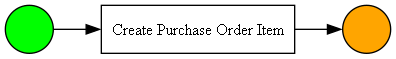

c:\Users\jessen_u\AppData\Local\miniconda3\envs\WISE\Lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


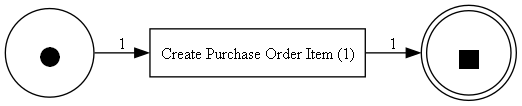

eventID case_Spend_area_text    case_Company  \
6518  1062720937918464                Sales  companyID_0000   

     case_Document_Type case_Sub_spend_area_text  case_Purchasing_Document  \
6518        Standard PO         Color Collateral                4508074944   

     case_Purch._Doc._Category_name    case_Vendor case_Item_Type  \
6518                 Purchase order  vendorID_0188    Consignment   

     case_Item_Category case_Spend_classification_text          case_Source  \
6518        Consignment                            NPR  sourceSystemID_0000   

        case_Name  case_GR-Based_Inv._Verif.  case_Item case_concept_name  \
6518  vendor_0185                      False         60  4508074944_00060   

      case_Goods_Receipt event_User event_org_resource  \
6518                True   user_102           user_102   

              event_concept_name  event_Cumulative_net_worth_(EUR)  \
6518  Create Purchase Order Item                               0.0   

          event_time_timestamp                concept:name  \
6518 2018-12-18 11:23:00+00:00  Create Purchase Order Item   

                time:timestamp  @@index  @@case_index case:concept:name  \
6518 2018-12-18 11:23:00+00:00  1579937        247831  4508074944_00060   

               start_timestamp  
6518 2018-12-18 11:23:00+00:00

In [ ]:
def vis_po(log, po_number,vis=True, print_log=False):
    sing_log = log[log['case_Purchasing_Document'] == po_number]
    if print_log:
        print(len(sing_log))
        print(sing_log.case_concept_name.unique())
        #print(sing_log)
    if vis:
        bpmn_graph = pm4py.discover_bpmn_inductive(sing_log, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
        pm4py.view_bpmn(bpmn_graph)
        dfg, start_activities, end_activities = pm4py.discover_dfg(sing_log, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
        pm4py.view_dfg(dfg, start_activities, end_activities)
    return sing_log

vis_po(log, 4508074944, vis=True, print_log=True)

In [ ]:
#show only traces where start activity is 'Vendor creates invoice' with pm4py
filtered_log = pm4py.filter_start_activities(log, {'Vendor creates invoice'})
one_po = filtered_log[filtered_log['case_Purchasing_Document'] == 2000000100]
print(one_po)

          eventID case_Spend_area_text    case_Company case_Document_Type  \
0    536870912000            Marketing  companyID_0000  EC Purchase order   
1    536870912001            Marketing  companyID_0000  EC Purchase order   
2    536870912209            Marketing  companyID_0000  EC Purchase order   
3    536870912296            Marketing  companyID_0000  EC Purchase order   
4    536870912297            Marketing  companyID_0000  EC Purchase order   
5    536870912298            Marketing  companyID_0000  EC Purchase order   
6    536870912299            Marketing  companyID_0000  EC Purchase order   
7    536870912002            Marketing  companyID_0000  EC Purchase order   
8    536870912003            Marketing  companyID_0000  EC Purchase order   
9    536870912004            Marketing  companyID_0000  EC Purchase order   
10   536870912005            Marketing  companyID_0000  EC Purchase order   
11   536870912006            Marketing  companyID_0000  EC Purchase order   

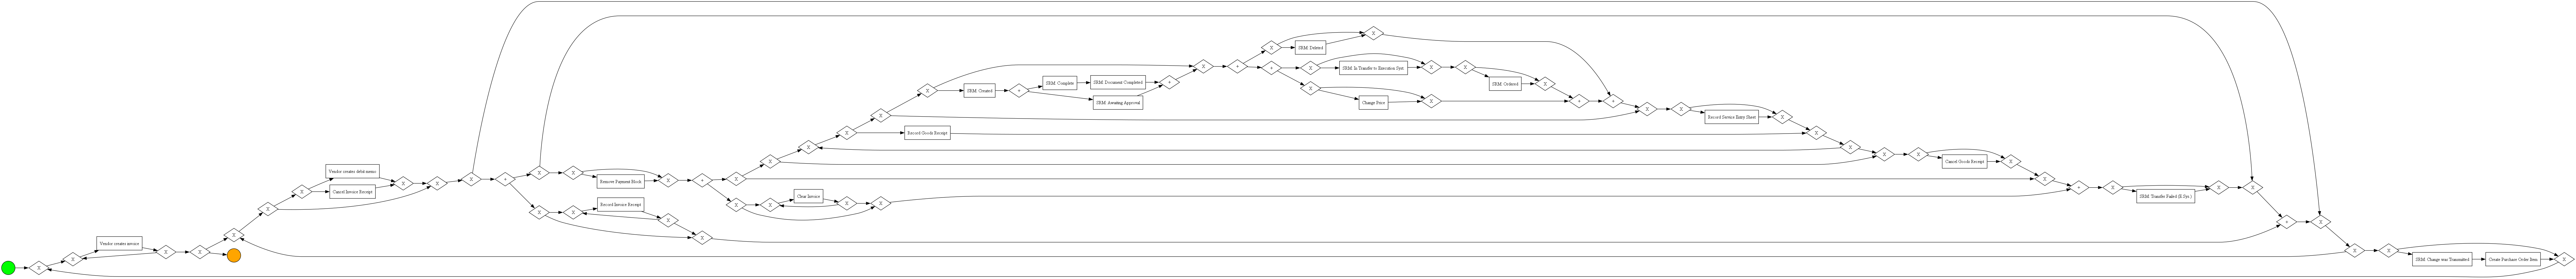

c:\Users\jessen_u\AppData\Local\miniconda3\envs\WISE\Lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


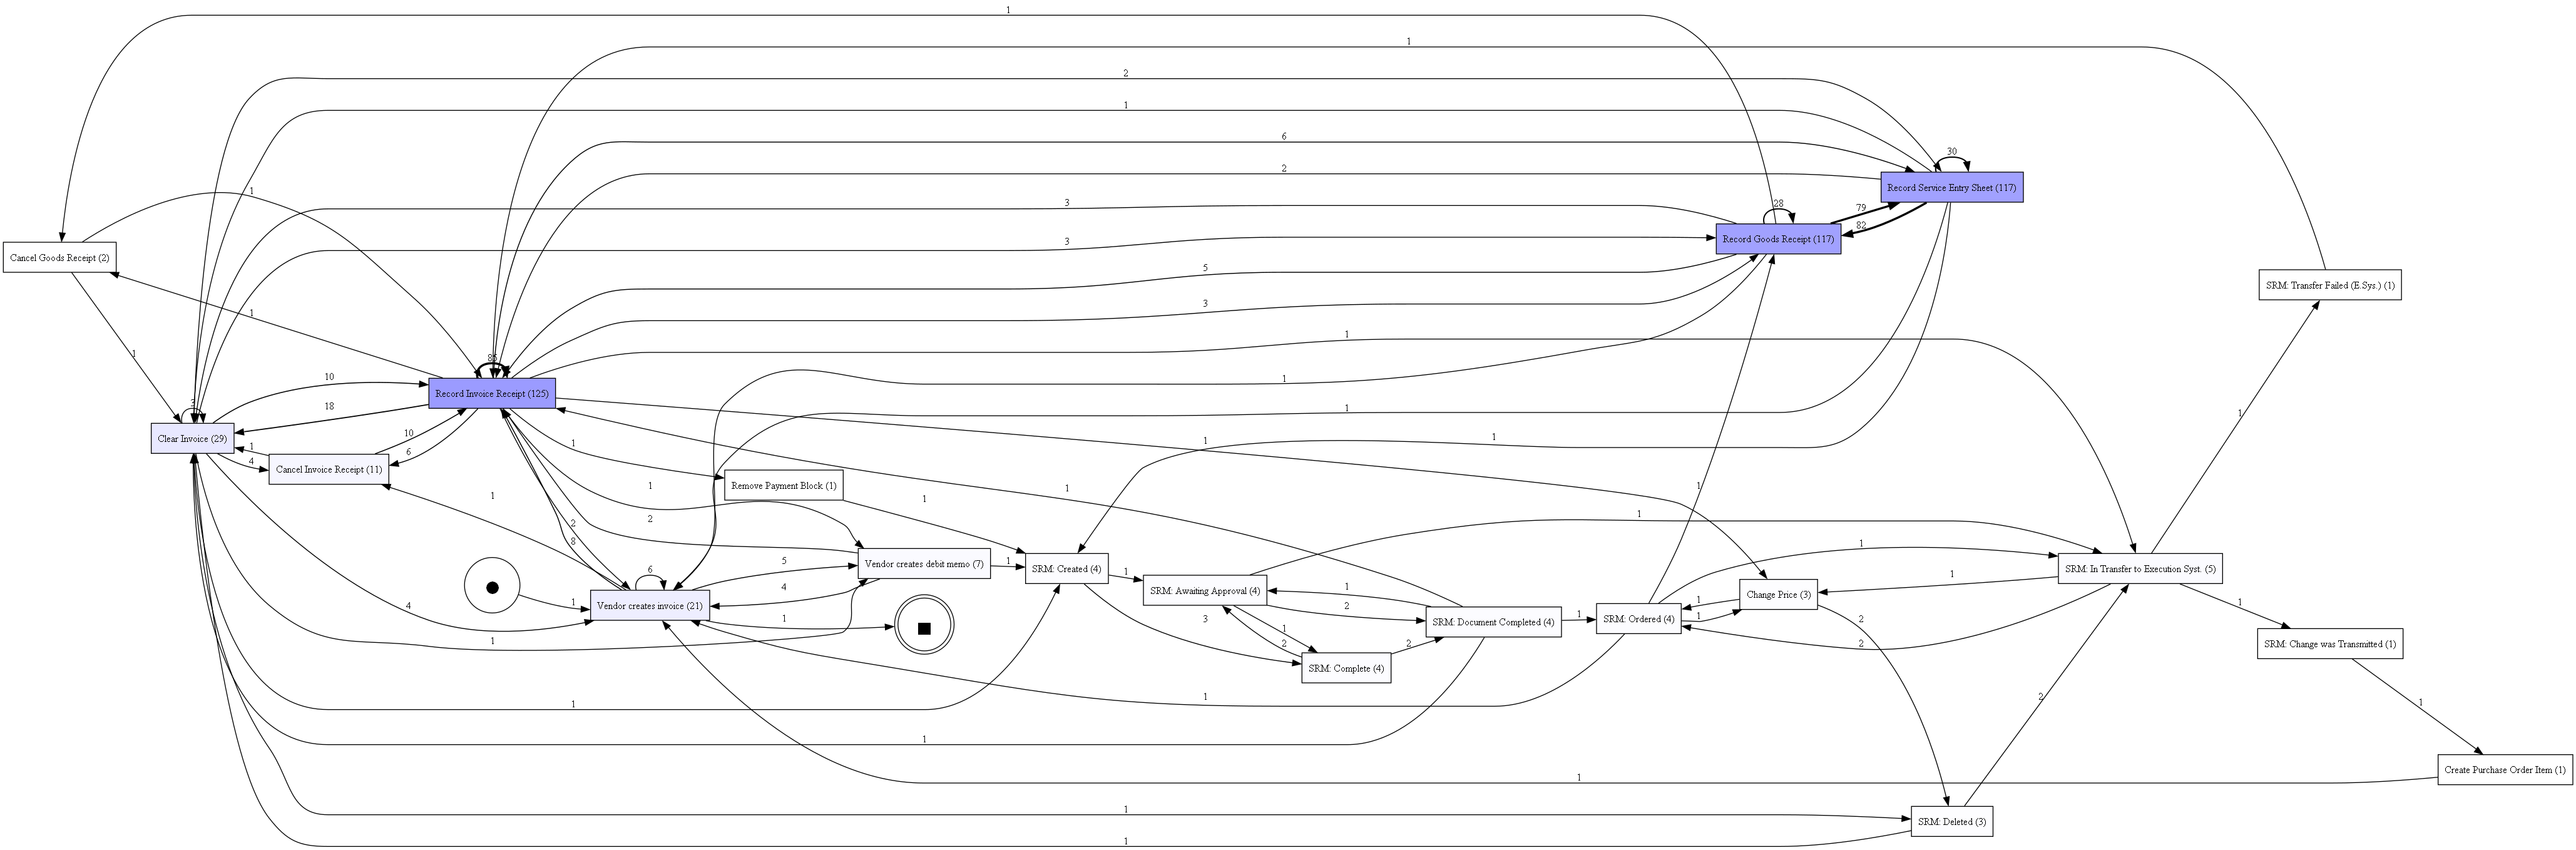

In [ ]:
bpmn_graph = pm4py.discover_bpmn_inductive(one_po, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
pm4py.view_bpmn(bpmn_graph)
dfg, start_activities, end_activities = pm4py.discover_dfg(one_po, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
pm4py.view_dfg(dfg, start_activities, end_activities)